In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def create_solana_lstm_sequences(raw_input_file="E:\\BAMD\\Solana\\Solana_daily_data_2018_2024.csv", 
                                 output_filename="solana_lstm_pytorch_data.npz",
                                 lookback_window=30): # Look back 30 days
    """
    Prepares Solana DAILY data for a standard LSTM model. It uses only raw OHLCV
    features and creates multi-day prediction targets.
    """
    print("--- Starting Data Preparation for Solana Standard LSTM ---")
    
    try:
        df = pd.read_csv(raw_input_file)
        print(f"1. Reading raw Solana data from '{raw_input_file}' ({len(df)} rows)...")
    except FileNotFoundError:
        print(f"ERROR: Raw input file '{raw_input_file}' not found.")
        return

    # --- Data Cleaning and Formatting for Daily Data ---
    print("2. Adapting to Solana daily data format...")
    df['time'] = pd.to_datetime(df['time'])
    df.sort_values('time', inplace=True)
    df.reset_index(drop=True, inplace=True)

    print("3. Creating multi-horizon DAILY targets...")
    prediction_horizons = {
        "Target_1_Day_Pct_Change": 1,
        "Target_7_Day_Pct_Change": 7,
        "Target_30_Day_Pct_Change": 30,
        "Target_90_Day_Pct_Change": 90
    }
    for name, horizon in prediction_horizons.items():
        future_price = df['Open'].shift(-horizon)
        df[name] = ((future_price - df['Close']) / df['Close']) * 100

    # --- THIS IS THE KEY CHANGE FOR A "STANDARD" LSTM ---
    # We are ONLY using the raw OHLCV data as features.
    features_to_use = ['Open', 'High', 'Low', 'Close', 'Volume']
    target_cols = list(prediction_horizons.keys())
    
    # Drop NaNs created by target generation to align data
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

    df_features = df[features_to_use]
    df_targets = df[target_cols]

    print("4. Scaling feature data...")
    feature_scaler = MinMaxScaler()
    scaled_features = feature_scaler.fit_transform(df_features.astype('float32'))

    print(f"5. Creating sequences with a {lookback_window}-day lookback...")
    X, y = [], []
    for i in range(lookback_window, len(scaled_features)):
        X.append(scaled_features[i - lookback_window:i])
        y.append(df_targets.iloc[i].values)

    X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)
    
    print(f"   Created {len(X)} sequences. Shape: {X.shape}")

    print("6. Splitting and saving final data...")
    n_total = len(X)
    n_train = int(n_total * 0.85)
    X_train, y_train = X[:n_train], y[:n_train]
    X_test, y_test = X[n_train:], y[n_train:]

    np.savez_compressed(output_filename,
        X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
        feature_scaler=np.array([feature_scaler]), target_cols=np.array(target_cols)
    )
    print(f"\n--- SUCCESS: Solana Standard LSTM data preparation complete. ---")

if __name__ == "__main__":
    create_solana_lstm_sequences()

--- Starting Data Preparation for Solana Standard LSTM ---
1. Reading raw Solana data from 'E:\BAMD\Solana\Solana_daily_data_2018_2024.csv' (1368 rows)...
2. Adapting to Solana daily data format...
3. Creating multi-horizon DAILY targets...
4. Scaling feature data...
5. Creating sequences with a 30-day lookback...
   Created 1248 sequences. Shape: (1248, 30, 5)
6. Splitting and saving final data...

--- SUCCESS: Solana Standard LSTM data preparation complete. ---


In [8]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error

# Configuration Dictionary
config = {
    "batch_size": 16,
    "hidden_units": 40,
    "learning_rate": 0.001,
    "epochs": 100,
    "patience": 10,
}

# The model class name is generic, it works for standard or hybrid LSTMs
# as it adapts to the number of input features automatically.
class LSTMModel(nn.Module):
    def __init__(self, input_features, hidden_units, num_outputs):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_features, hidden_size=hidden_units, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(input_size=hidden_units, hidden_size=hidden_units, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(in_features=hidden_units, out_features=25)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_features=25, out_features=num_outputs)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.dropout1(out)
        out, _ = self.lstm2(out)
        out = self.dropout2(out)
        out = out[:, -1, :]
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

class EarlyStopper:
    def __init__(self, patience, model_path):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.model_path = model_path

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.model_path)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print(f"--- Early stopping triggered after {self.patience} epochs. ---")
                return True
        return False

# Main Training and Evaluation Function
def main():
    print("--- Starting Solana PyTorch Standard LSTM Model Training ---")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"1. Using device: {device}")
    
    data_filename = "solana_lstm_pytorch_data.npz"
    model_path = "solana_lstm_pytorch_model.pth"

    try:
        with np.load(data_filename, allow_pickle=True) as data:
            X_train, y_train, X_test, y_test, target_cols = data['X_train'], data['y_train'], data['X_test'], data['y_test'], data['target_cols']
    except FileNotFoundError:
        print(f"ERROR: Data file '{data_filename}' not found. Please run the preparation script first.")
        return

    val_split = int(len(X_train) * 0.85)
    X_train, X_val = X_train[:val_split], X_train[val_split:]
    y_train, y_val = y_train[:val_split], y_train[val_split:]

    train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float()), batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float()), batch_size=config["batch_size"])

    model = LSTMModel(X_train.shape[2], config["hidden_units"], y_train.shape[1]).to(device)
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])
    early_stopper = EarlyStopper(patience=config["patience"], model_path=model_path)

    print(f"2. Starting training for up to {config['epochs']} epochs...")
    for epoch in range(config["epochs"]):
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch+1}/{config['epochs']}, Val Loss: {avg_val_loss:.4f}")
        if early_stopper(avg_val_loss, model):
            break
            
    print("\n3. Evaluating model on the test set...")
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    with torch.no_grad():
        test_preds_t = model(torch.from_numpy(X_test).float().to(device))
    
    predictions = test_preds_t.cpu().numpy()
    evaluation_results = {col: mean_absolute_error(y_test[:, i], predictions[:, i]) for i, col in enumerate(target_cols)}
    
    print("\n--- Solana PyTorch Standard LSTM Evaluation Results ---")
    results_df = pd.DataFrame.from_dict(evaluation_results, orient='index', columns=['MAE (%)'])
    print(results_df)
    print("---------------------------------------------")

if __name__ == "__main__":
    main()

--- Starting Solana PyTorch Standard LSTM Model Training ---
1. Using device: cuda
2. Starting training for up to 100 epochs...
Epoch 1/100, Val Loss: 57.6705
Epoch 2/100, Val Loss: 57.9528
Epoch 3/100, Val Loss: 57.3141
Epoch 4/100, Val Loss: 56.9940
Epoch 5/100, Val Loss: 56.8250
Epoch 6/100, Val Loss: 56.4873
Epoch 7/100, Val Loss: 55.9484
Epoch 8/100, Val Loss: 55.6326
Epoch 9/100, Val Loss: 55.6156
Epoch 10/100, Val Loss: 56.4562
Epoch 11/100, Val Loss: 56.6809
Epoch 12/100, Val Loss: 56.7814
Epoch 13/100, Val Loss: 56.8502
Epoch 14/100, Val Loss: 56.9326
Epoch 15/100, Val Loss: 56.9458
Epoch 16/100, Val Loss: 56.9778
Epoch 17/100, Val Loss: 57.0203
Epoch 18/100, Val Loss: 57.0435
Epoch 19/100, Val Loss: 56.9859
--- Early stopping triggered after 10 epochs. ---

3. Evaluating model on the test set...

--- Solana PyTorch Standard LSTM Evaluation Results ---
                            MAE (%)
Target_1_Day_Pct_Change    0.015471
Target_7_Day_Pct_Change    8.292795
Target_30_Day_Pct_

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def create_solana_lstm_sequences(raw_input_file="E:\\BAMD\\Solana\\Solana_daily_data_2018_2024.csv", 
                                 output_filename="solana_lstm_pytorch_data.npz",
                                 lookback_window=30):
    """
    Prepares Solana DAILY data for a standard LSTM model. (Corrected v2)
    This version ensures robust NaN handling to prevent data contamination.
    """
    print("--- Starting Data Preparation for Solana Standard LSTM (Corrected v2) ---")
    
    try:
        df = pd.read_csv(raw_input_file)
        print(f"1. Reading raw Solana data from '{raw_input_file}' ({len(df)} rows)...")
    except FileNotFoundError:
        print(f"ERROR: Raw input file '{raw_input_file}' not found.")
        return

    print("2. Adapting to Solana daily data format...")
    df['time'] = pd.to_datetime(df['time'])
    df.sort_values('time', inplace=True)
    df.reset_index(drop=True, inplace=True)

    # --- ROBUST DATA CLEANING APPROACH ---
    # Step A: Create ALL potential columns first (targets and features)
    print("3. Creating all target and feature columns...")

    # Create targets
    prediction_horizons = {
        "Target_1_Day_Pct_Change": 1, "Target_7_Day_Pct_Change": 7,
        "Target_30_Day_Pct_Change": 30, "Target_90_Day_Pct_Change": 90
    }
    for name, horizon in prediction_horizons.items():
        future_price = df['Open'].shift(-horizon)
        df[name] = ((future_price - df['Close']) / df['Close']) * 100

    # Create all engineered features, even if not used by this model,
    # to identify all rows with potential NaN values from rolling windows.
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    
    # Step B: Drop ALL rows with ANY NaN values.
    # This cleans the data from both the start (from rolling features) and
    # the end (from shifted targets) of the DataFrame.
    print("4. Dropping all rows with NaN values to ensure data integrity...")
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    # Step C: Now, select the final columns for this specific model
    print("5. Selecting final features for the Standard LSTM model...")
    features_to_use = ['Open', 'High', 'Low', 'Close', 'Volume']
    target_cols = list(prediction_horizons.keys())

    df_features = df[features_to_use]
    df_targets = df[target_cols]

    # --- The rest of the script remains the same ---
    print("6. Scaling feature data...")
    feature_scaler = MinMaxScaler()
    scaled_features = feature_scaler.fit_transform(df_features.astype('float32'))

    print(f"7. Creating sequences with a {lookback_window}-day lookback...")
    X, y = [], []
    for i in range(lookback_window, len(scaled_features)):
        X.append(scaled_features[i - lookback_window:i])
        y.append(df_targets.iloc[i].values)

    X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)
    
    print(f"   Created {len(X)} sequences. Shape: {X.shape}")

    print("8. Splitting and saving final data...")
    n_total = len(X)
    n_train = int(n_total * 0.85)
    X_train, y_train = X[:n_train], y[:n_train]
    X_test, y_test = X[n_train:], y[n_train:]

    np.savez_compressed(output_filename,
        X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
        feature_scaler=np.array([feature_scaler]), target_cols=np.array(target_cols)
    )
    print(f"\n--- SUCCESS: Solana Standard LSTM data preparation complete. ---")

if __name__ == "__main__":
    create_solana_lstm_sequences()

--- Starting Data Preparation for Solana Standard LSTM (Corrected v2) ---
1. Reading raw Solana data from 'E:\BAMD\Solana\Solana_daily_data_2018_2024.csv' (1368 rows)...
2. Adapting to Solana daily data format...
3. Creating all target and feature columns...
4. Dropping all rows with NaN values to ensure data integrity...
5. Selecting final features for the Standard LSTM model...
6. Scaling feature data...
7. Creating sequences with a 30-day lookback...
   Created 1199 sequences. Shape: (1199, 30, 5)
8. Splitting and saving final data...

--- SUCCESS: Solana Standard LSTM data preparation complete. ---


In [10]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error

# Configuration Dictionary
config = {
    "batch_size": 16,
    "hidden_units": 40,
    "learning_rate": 0.001,
    "epochs": 100,
    "patience": 10,
}

# The model class name is generic, it works for standard or hybrid LSTMs
# as it adapts to the number of input features automatically.
class LSTMModel(nn.Module):
    def __init__(self, input_features, hidden_units, num_outputs):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_features, hidden_size=hidden_units, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(input_size=hidden_units, hidden_size=hidden_units, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(in_features=hidden_units, out_features=25)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_features=25, out_features=num_outputs)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.dropout1(out)
        out, _ = self.lstm2(out)
        out = self.dropout2(out)
        out = out[:, -1, :]
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

class EarlyStopper:
    def __init__(self, patience, model_path):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.model_path = model_path

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.model_path)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print(f"--- Early stopping triggered after {self.patience} epochs. ---")
                return True
        return False

# Main Training and Evaluation Function
def main():
    print("--- Starting Solana PyTorch Standard LSTM Model Training ---")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"1. Using device: {device}")
    
    data_filename = "solana_lstm_pytorch_data.npz"
    model_path = "solana_lstm_pytorch_model.pth"

    try:
        with np.load(data_filename, allow_pickle=True) as data:
            X_train, y_train, X_test, y_test, target_cols = data['X_train'], data['y_train'], data['X_test'], data['y_test'], data['target_cols']
    except FileNotFoundError:
        print(f"ERROR: Data file '{data_filename}' not found. Please run the preparation script first.")
        return

    val_split = int(len(X_train) * 0.85)
    X_train, X_val = X_train[:val_split], X_train[val_split:]
    y_train, y_val = y_train[:val_split], y_train[val_split:]

    train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float()), batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float()), batch_size=config["batch_size"])

    model = LSTMModel(X_train.shape[2], config["hidden_units"], y_train.shape[1]).to(device)
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])
    early_stopper = EarlyStopper(patience=config["patience"], model_path=model_path)

    print(f"2. Starting training for up to {config['epochs']} epochs...")
    for epoch in range(config["epochs"]):
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch+1}/{config['epochs']}, Val Loss: {avg_val_loss:.4f}")
        if early_stopper(avg_val_loss, model):
            break
            
    print("\n3. Evaluating model on the test set...")
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    with torch.no_grad():
        test_preds_t = model(torch.from_numpy(X_test).float().to(device))
    
    predictions = test_preds_t.cpu().numpy()
    evaluation_results = {col: mean_absolute_error(y_test[:, i], predictions[:, i]) for i, col in enumerate(target_cols)}
    
    print("\n--- Solana PyTorch Standard LSTM Evaluation Results ---")
    results_df = pd.DataFrame.from_dict(evaluation_results, orient='index', columns=['MAE (%)'])
    print(results_df)
    print("---------------------------------------------")

if __name__ == "__main__":
    main()

--- Starting Solana PyTorch Standard LSTM Model Training ---
1. Using device: cuda
2. Starting training for up to 100 epochs...
Epoch 1/100, Val Loss: 58.5350
Epoch 2/100, Val Loss: 59.1786
Epoch 3/100, Val Loss: 58.4483
Epoch 4/100, Val Loss: 58.3518
Epoch 5/100, Val Loss: 60.4461
Epoch 6/100, Val Loss: 60.9725
Epoch 7/100, Val Loss: 60.4784
Epoch 8/100, Val Loss: 58.9916
Epoch 9/100, Val Loss: 58.6895
Epoch 10/100, Val Loss: 58.5616
Epoch 11/100, Val Loss: 58.6275
Epoch 12/100, Val Loss: 58.4564
Epoch 13/100, Val Loss: 58.3645
Epoch 14/100, Val Loss: 58.4424
--- Early stopping triggered after 10 epochs. ---

3. Evaluating model on the test set...

--- Solana PyTorch Standard LSTM Evaluation Results ---
                            MAE (%)
Target_1_Day_Pct_Change    0.010062
Target_7_Day_Pct_Change    8.546630
Target_30_Day_Pct_Change  27.333059
Target_90_Day_Pct_Change  32.842335
---------------------------------------------


In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def create_solana_lstm_sequences(raw_input_file="E:\\BAMD\\Solana\\Solana_daily_data_2018_2024.csv", 
                                 output_filename="solana_lstm_pytorch_data.npz",
                                 lookback_window=30): 
    """
    Prepares Solana DAILY data for a standard LSTM model. It uses only raw OHLCV
    features and creates multi-day prediction targets.
    """
    print("--- Starting Data Preparation for Solana Standard LSTM ---")
    
    try:
        df = pd.read_csv(raw_input_file)
        print(f"1. Reading raw Solana data from '{raw_input_file}' ({len(df)} rows)...")
    except FileNotFoundError:
        print(f"ERROR: Raw input file '{raw_input_file}' not found.")
        return

    print("2. Adapting to Solana daily data format...")
    df['time'] = pd.to_datetime(df['time'])
    df.sort_values('time', inplace=True)
    df.reset_index(drop=True, inplace=True)

    print("3. Creating all target and feature columns for robust NaN handling...")
    prediction_horizons = {
        "Target_1_Day_Pct_Change": 1, "Target_7_Day_Pct_Change": 7,
        "Target_30_Day_Pct_Change": 30, "Target_90_Day_Pct_Change": 90
    }
    # This loop ensures exactly 4 target columns are created
    for name, horizon in prediction_horizons.items():
        future_price = df['Open'].shift(-horizon)
        df[name] = ((future_price - df['Close']) / df['Close']) * 100

    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    print("4. Selecting final features for the Standard LSTM model...")
    features_to_use = ['Open', 'High', 'Low', 'Close', 'Volume']
    target_cols = list(prediction_horizons.keys()) # Ensures target_cols has 4 names

    df_features = df[features_to_use]
    df_targets = df[target_cols]

    print("5. Scaling feature data...")
    feature_scaler = MinMaxScaler()
    scaled_features = feature_scaler.fit_transform(df_features.astype('float32'))

    print(f"6. Creating sequences with a {lookback_window}-day lookback...")
    X, y = [], []
    for i in range(lookback_window, len(scaled_features)):
        X.append(scaled_features[i - lookback_window:i])
        y.append(df_targets.iloc[i].values)

    X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)
    
    print(f"   Created {len(X)} sequences. Shape: {X.shape}")

    print("7. Splitting and saving final data...")
    n_total = len(X)
    n_train = int(n_total * 0.85)
    X_train, y_train = X[:n_train], y[:n_train]
    X_test, y_test = X[n_train:], y[n_train:]

    np.savez_compressed(output_filename,
        X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
        feature_scaler=np.array([feature_scaler]), target_cols=np.array(target_cols)
    )
    print(f"\n--- SUCCESS: Solana Standard LSTM data preparation complete. ---")

if __name__ == "__main__":
    create_solana_lstm_sequences()

--- Starting Data Preparation for Solana Standard LSTM ---
1. Reading raw Solana data from 'E:\BAMD\Solana\Solana_daily_data_2018_2024.csv' (1368 rows)...
2. Adapting to Solana daily data format...
3. Creating all target and feature columns for robust NaN handling...
4. Selecting final features for the Standard LSTM model...
5. Scaling feature data...
6. Creating sequences with a 30-day lookback...
   Created 1199 sequences. Shape: (1199, 30, 5)
7. Splitting and saving final data...

--- SUCCESS: Solana Standard LSTM data preparation complete. ---


In [12]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error

config = {
    "batch_size": 16,
    "hidden_units": 40,
    "learning_rate": 0.001,
    "epochs": 100,
    "patience": 10,
}

class LSTMModel(nn.Module):
    def __init__(self, input_features, hidden_units, num_outputs):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_features, hidden_size=hidden_units, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(input_size=hidden_units, hidden_size=hidden_units, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(in_features=hidden_units, out_features=25)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_features=25, out_features=num_outputs)

    def forward(self, x):
        out, _ = self.lstm1(x); out = self.dropout1(out)
        out, _ = self.lstm2(out); out = self.dropout2(out)
        out = out[:, -1, :]; out = self.fc1(out)
        out = self.relu(out); out = self.fc2(out)
        return out

class EarlyStopper:
    def __init__(self, patience, model_path):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.model_path = model_path

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.model_path)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print(f"--- Early stopping triggered after {self.patience} epochs. ---")
                return True
        return False

def main():
    print("--- Starting Solana PyTorch Standard LSTM Model Training ---")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"1. Using device: {device}")
    
    data_filename = "solana_lstm_pytorch_data.npz"
    model_path = "solana_lstm_pytorch_model.pth"

    try:
        with np.load(data_filename, allow_pickle=True) as data:
            X_train, y_train, X_test, y_test, target_cols = data['X_train'], data['y_train'], data['X_test'], data['y_test'], data['target_cols']
            # Ensure target_cols is a list or array
            target_cols = np.array(target_cols) # This will ensure it's iterable correctly
    except FileNotFoundError:
        print(f"ERROR: Data file '{data_filename}' not found. Please run the preparation script first.")
        return

    val_split = int(len(X_train) * 0.85)
    X_train, X_val = X_train[:val_split], X_train[val_split:]
    y_train, y_val = y_train[:val_split], y_train[val_split:]

    train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float()), batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float()), batch_size=config["batch_size"])

    model = LSTMModel(X_train.shape[2], config["hidden_units"], y_train.shape[1]).to(device) # y_train.shape[1] is now guaranteed to be 4
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])
    early_stopper = EarlyStopper(patience=config["patience"], model_path=model_path)

    print(f"2. Starting training for up to {config['epochs']} epochs...")
    for epoch in range(config["epochs"]):
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch+1}/{config['epochs']}, Val Loss: {avg_val_loss:.4f}")
        if early_stopper(avg_val_loss, model):
            break
            
    print("\n3. Evaluating model on the test set...")
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    with torch.no_grad():
        test_preds_t = model(torch.from_numpy(X_test).float().to(device))
    
    predictions = test_preds_t.cpu().numpy()
    evaluation_results = {col: mean_absolute_error(y_test[:, i], predictions[:, i]) for i, col in enumerate(target_cols)}
    
    print("\n--- Solana PyTorch Standard LSTM Evaluation Results ---")
    results_df = pd.DataFrame.from_dict(evaluation_results, orient='index', columns=['MAE (%)'])
    print(results_df)
    print("---------------------------------------------")

if __name__ == "__main__":
    main()

--- Starting Solana PyTorch Standard LSTM Model Training ---
1. Using device: cuda
2. Starting training for up to 100 epochs...
Epoch 1/100, Val Loss: 58.5055
Epoch 2/100, Val Loss: 58.8501
Epoch 3/100, Val Loss: 59.5378
Epoch 4/100, Val Loss: 58.9852
Epoch 5/100, Val Loss: 61.1670
Epoch 6/100, Val Loss: 58.4388
Epoch 7/100, Val Loss: 60.7021
Epoch 8/100, Val Loss: 58.1438
Epoch 9/100, Val Loss: 58.3040
Epoch 10/100, Val Loss: 59.7881
Epoch 11/100, Val Loss: 59.6679
Epoch 12/100, Val Loss: 57.9516
Epoch 13/100, Val Loss: 58.1190
Epoch 14/100, Val Loss: 58.3342
Epoch 15/100, Val Loss: 58.4345
Epoch 16/100, Val Loss: 58.5220
Epoch 17/100, Val Loss: 58.6390
Epoch 18/100, Val Loss: 58.8274
Epoch 19/100, Val Loss: 59.1035
Epoch 20/100, Val Loss: 59.6339
Epoch 21/100, Val Loss: 60.0595
Epoch 22/100, Val Loss: 60.0332
--- Early stopping triggered after 10 epochs. ---

3. Evaluating model on the test set...

--- Solana PyTorch Standard LSTM Evaluation Results ---
                            MA

In [13]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error

# Configuration Dictionary
config = {
    "batch_size": 16,
    "hidden_units": 40,
    "learning_rate": 0.001,
    "epochs": 100,
    "patience": 10,
}

# The model and early stopper classes are the same
class LSTMModel(nn.Module):
    def __init__(self, input_features, hidden_units, num_outputs):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_features, hidden_size=hidden_units, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(input_size=hidden_units, hidden_size=hidden_units, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(in_features=hidden_units, out_features=25)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_features=25, out_features=num_outputs)

    def forward(self, x):
        out, _ = self.lstm1(x); out = self.dropout1(out)
        out, _ = self.lstm2(out); out = self.dropout2(out)
        out = out[:, -1, :]; out = self.fc1(out)
        out = self.relu(out); out = self.fc2(out)
        return out

class EarlyStopper:
    def __init__(self, patience, model_path):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.model_path = model_path

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.model_path)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print(f"--- Early stopping triggered after {self.patience} epochs. ---")
                return True
        return False

# Main Training and Evaluation Function
def main():
    print("--- Starting Solana PyTorch LSTM Model Training (with CSV Export) ---")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"1. Using device: {device}")
    
    data_filename = "solana_lstm_pytorch_data.npz"
    model_path = "solana_lstm_pytorch_model.pth"
    output_csv_path = "solana_predictions_vs_actuals.csv" # <-- NEW: Output filename

    try:
        with np.load(data_filename, allow_pickle=True) as data:
            X_train, y_train, X_test, y_test, target_cols = data['X_train'], data['y_train'], data['X_test'], data['y_test'], data['target_cols']
    except FileNotFoundError:
        print(f"ERROR: Data file '{data_filename}' not found. Please run the preparation script first.")
        return

    val_split = int(len(X_train) * 0.85)
    X_train, X_val = X_train[:val_split], X_train[val_split:]
    y_train, y_val = y_train[:val_split], y_train[val_split:]

    train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float()), batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float()), batch_size=config["batch_size"])

    model = LSTMModel(X_train.shape[2], config["hidden_units"], y_train.shape[1]).to(device)
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])
    early_stopper = EarlyStopper(patience=config["patience"], model_path=model_path)

    print(f"2. Starting training for up to {config['epochs']} epochs...")
    for epoch in range(config["epochs"]):
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch+1}/{config['epochs']}, Val Loss: {avg_val_loss:.4f}")
        if early_stopper(avg_val_loss, model):
            break
            
    print("\n3. Evaluating model on the test set...")
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    # Use batches for evaluation to prevent memory errors
    test_loader = DataLoader(TensorDataset(torch.from_numpy(X_test).float()), batch_size=config["batch_size"] * 2)
    all_preds = []
    with torch.no_grad():
        for batch_X_tuple in test_loader:
            preds = model(batch_X_tuple[0].to(device))
            all_preds.append(preds.cpu().numpy())
    predictions = np.concatenate(all_preds, axis=0)
    
    evaluation_results = {col: mean_absolute_error(y_test[:, i], predictions[:, i]) for i, col in enumerate(target_cols)}
    
    print("\n--- Solana PyTorch Standard LSTM Evaluation Results ---")
    results_df = pd.DataFrame.from_dict(evaluation_results, orient='index', columns=['MAE (%)'])
    print(results_df)
    print("---------------------------------------------")

    # --- NEW: EXPORT PREDICTIONS TO CSV ---
    print(f"\n4. Exporting test set predictions to '{output_csv_path}'...")
    
    # Create column names for predictions
    pred_col_names = [f"Pred_{name.replace('Target_', '')}" for name in target_cols]
    
    # Create DataFrames
    actuals_df = pd.DataFrame(y_test, columns=target_cols)
    predictions_df = pd.DataFrame(predictions, columns=pred_col_names)
    
    # Concatenate them side-by-side
    final_df = pd.concat([actuals_df, predictions_df], axis=1)
    
    # Save to CSV
    final_df.to_csv(output_csv_path, index=False, float_format='%.6f')
    print("   ...Export complete.")

if __name__ == "__main__":
    main()

--- Starting Solana PyTorch LSTM Model Training (with CSV Export) ---
1. Using device: cuda
2. Starting training for up to 100 epochs...
Epoch 1/100, Val Loss: 58.7577
Epoch 2/100, Val Loss: 59.9406
Epoch 3/100, Val Loss: 60.6600
Epoch 4/100, Val Loss: 59.6552
Epoch 5/100, Val Loss: 58.8708
Epoch 6/100, Val Loss: 58.4550
Epoch 7/100, Val Loss: 60.3542
Epoch 8/100, Val Loss: 60.4699
Epoch 9/100, Val Loss: 60.9068
Epoch 10/100, Val Loss: 60.7207
Epoch 11/100, Val Loss: 60.6586
Epoch 12/100, Val Loss: 60.3505
Epoch 13/100, Val Loss: 57.7857
Epoch 14/100, Val Loss: 58.1585
Epoch 15/100, Val Loss: 58.2959
Epoch 16/100, Val Loss: 58.3787
Epoch 17/100, Val Loss: 58.4233
Epoch 18/100, Val Loss: 58.5018
Epoch 19/100, Val Loss: 58.5933
Epoch 20/100, Val Loss: 58.7548
Epoch 21/100, Val Loss: 59.2105
Epoch 22/100, Val Loss: 59.7453
Epoch 23/100, Val Loss: 60.0569
--- Early stopping triggered after 10 epochs. ---

3. Evaluating model on the test set...

--- Solana PyTorch Standard LSTM Evaluation R

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def create_solana_hybrid_sequences(raw_input_file="E:\BAMD\Solana\Solana_daily_data_2018_2024.csv", 
                                   output_filename="solana_hybrid_pytorch_data.npz",
                                   lookback_window=30):
    """
    Prepares Solana DAILY data for a Hybrid LSTM model by creating sequences that
    include both raw price data and engineered daily technical indicators.
    """
    print("--- Starting Data Preparation for Solana Hybrid LSTM Model ---")
    
    try:
        df = pd.read_csv(raw_input_file)
        print(f"1. Reading raw Solana data from '{raw_input_file}' ({len(df)} rows)...")
    except FileNotFoundError:
        print(f"ERROR: Raw input file '{raw_input_file}' not found.")
        return

    print("2. Adapting to Solana daily data format...")
    df['time'] = pd.to_datetime(df['time'])
    df.sort_values('time', inplace=True)
    df.reset_index(drop=True, inplace=True)

    print("3. Engineering daily technical indicators...")
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['Volume_SMA_50'] = df['Volume'].rolling(window=50).mean()
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0); loss = -delta.where(delta < 0, 0)
    with np.errstate(divide='ignore', invalid='ignore'):
        rs = gain.rolling(window=14).mean() / loss.rolling(window=14).mean()
    df['Feat_RSI'] = 100 - (100 / (1 + rs))
    df['Feat_Close_vs_SMA50'] = (df['Close'] - df['SMA_50']) / df['SMA_50']
    df['Feat_Volume_vs_SMA50'] = (df['Volume'] - df['Volume_SMA_50']) / df['Volume_SMA_50']

    print("4. Creating multi-horizon DAILY targets...")
    prediction_horizons = {
        "Target_1_Day_Pct_Change": 1, "Target_7_Day_Pct_Change": 7,
        "Target_30_Day_Pct_Change": 30, "Target_90_Day_Pct_Change": 90
    }
    for name, horizon in prediction_horizons.items():
        future_price = df['Open'].shift(-horizon)
        df[name] = ((future_price - df['Close']) / df['Close']) * 100

    features_to_use = [
        'Open', 'High', 'Low', 'Close', 'Volume', # Raw data
        'Feat_RSI', 'Feat_Close_vs_SMA50', 'Feat_Volume_vs_SMA50' # Engineered features
    ]
    target_cols = list(prediction_horizons.keys())
    
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

    df_features = df[features_to_use]; df_targets = df[target_cols]
    
    print("5. Scaling and Sequencing data...")
    feature_scaler = MinMaxScaler()
    scaled_features = feature_scaler.fit_transform(df_features.astype('float32'))

    X, y = [], []
    for i in range(lookback_window, len(scaled_features)):
        X.append(scaled_features[i - lookback_window:i])
        y.append(df_targets.iloc[i].values)

    X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)
    print(f"   Created {len(X)} sequences. Shape: {X.shape}")

    n_total = len(X)
    n_train = int(n_total * 0.85)
    X_train, y_train, X_test, y_test = X[:n_train], y[:n_train], X[n_train:], y[n_train:]
    
    np.savez_compressed(output_filename,
        X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
        feature_scaler=np.array([feature_scaler]), target_cols=np.array(target_cols)
    )
    print(f"\n--- SUCCESS: Solana Hybrid LSTM data preparation complete. Saved to '{output_filename}' ---")

if __name__ == "__main__":
    create_solana_hybrid_sequences()

--- Starting Data Preparation for Solana Hybrid LSTM Model ---
1. Reading raw Solana data from 'E:\BAMD\Solana\Solana_daily_data_2018_2024.csv' (1368 rows)...
2. Adapting to Solana daily data format...
3. Engineering daily technical indicators...
4. Creating multi-horizon DAILY targets...
5. Scaling and Sequencing data...
   Created 1199 sequences. Shape: (1199, 30, 8)

--- SUCCESS: Solana Hybrid LSTM data preparation complete. Saved to 'solana_hybrid_pytorch_data.npz' ---


In [15]:
import numpy as np; import pandas as pd; import torch; import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset; from sklearn.metrics import mean_absolute_error
config = {"batch_size": 16, "hidden_units": 40, "learning_rate": 0.001, "epochs": 100, "patience": 10}
class HybridLSTM(nn.Module):
    def __init__(self, input_features, hidden_units, num_outputs):
        super(HybridLSTM, self).__init__(); self.lstm1 = nn.LSTM(input_size=input_features, hidden_size=hidden_units, batch_first=True); self.dropout1 = nn.Dropout(0.2); self.lstm2 = nn.LSTM(input_size=hidden_units, hidden_size=hidden_units, batch_first=True); self.dropout2 = nn.Dropout(0.2); self.fc1 = nn.Linear(in_features=hidden_units, out_features=25); self.relu = nn.ReLU(); self.fc2 = nn.Linear(in_features=25, out_features=num_outputs)
    def forward(self, x):
        out, _ = self.lstm1(x); out = self.dropout1(out); out, _ = self.lstm2(out); out = self.dropout2(out); out = out[:, -1, :]; out = self.fc1(out); out = self.relu(out); out = self.fc2(out); return out
class EarlyStopper:
    def __init__(self, patience, model_path):
        self.patience = patience; self.counter = 0; self.best_loss = float('inf'); self.model_path = model_path
    def __call__(self, val_loss, model):
        if val_loss < self.best_loss: self.best_loss = val_loss; self.counter = 0; torch.save(model.state_dict(), self.model_path)
        else:
            self.counter += 1
            if self.counter >= self.patience: print(f"--- Early stopping after {self.patience} epochs. ---"); return True
        return False
def main():
    print("--- Starting Solana PyTorch Hybrid LSTM Model Training ---"); device = "cuda" if torch.cuda.is_available() else "cpu"; print(f"1. Using device: {device}")
    data_filename = "solana_hybrid_pytorch_data.npz"; model_path = "solana_hybrid_pytorch_model.pth"
    with np.load(data_filename, allow_pickle=True) as data: X_train, y_train, X_test, y_test, target_cols = data['X_train'], data['y_train'], data['X_test'], data['y_test'], data['target_cols']
    val_split = int(len(X_train) * 0.85); X_train, X_val, y_train, y_val = X_train[:val_split], X_train[val_split:], y_train[:val_split], y_train[val_split:]
    train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float()), batch_size=config["batch_size"], shuffle=True); val_loader = DataLoader(TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float()), batch_size=config["batch_size"])
    model = HybridLSTM(X_train.shape[2], config["hidden_units"], y_train.shape[1]).to(device); criterion = nn.L1Loss(); optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"]); early_stopper = EarlyStopper(patience=config["patience"], model_path=model_path)
    print(f"2. Starting training for up to {config['epochs']} epochs...");
    for epoch in range(config["epochs"]):
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device); optimizer.zero_grad(); outputs = model(batch_X); loss = criterion(outputs, batch_y); loss.backward(); optimizer.step()
        model.eval(); val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader: batch_X, batch_y = batch_X.to(device), batch_y.to(device); outputs = model(batch_X); loss = criterion(outputs, batch_y); val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader); print(f"Epoch {epoch+1}/{config['epochs']}, Val Loss: {avg_val_loss:.4f}")
        if early_stopper(avg_val_loss, model): break
    print("\n3. Evaluating model on the test set..."); model.load_state_dict(torch.load(model_path)); model.eval()
    test_loader = DataLoader(TensorDataset(torch.from_numpy(X_test).float()), batch_size=config["batch_size"]*2); all_preds = []
    with torch.no_grad():
        for batch_X_tuple in test_loader: preds = model(batch_X_tuple[0].to(device)); all_preds.append(preds.cpu().numpy())
    predictions = np.concatenate(all_preds, axis=0); evaluation_results = {col: mean_absolute_error(y_test[:, i], predictions[:, i]) for i, col in enumerate(target_cols)}
    print("\n--- Solana PyTorch Hybrid LSTM Evaluation Results ---"); results_df = pd.DataFrame.from_dict(evaluation_results, orient='index', columns=['MAE (%)']); print(results_df); print("---------------------------------------------")
if __name__ == "__main__": main()

--- Starting Solana PyTorch Hybrid LSTM Model Training ---
1. Using device: cuda
2. Starting training for up to 100 epochs...
Epoch 1/100, Val Loss: 58.5294
Epoch 2/100, Val Loss: 59.1926
Epoch 3/100, Val Loss: 59.2964
Epoch 4/100, Val Loss: 58.5167
Epoch 5/100, Val Loss: 58.7380
Epoch 6/100, Val Loss: 65.5095
Epoch 7/100, Val Loss: 59.1107
Epoch 8/100, Val Loss: 62.0774
Epoch 9/100, Val Loss: 60.3896
Epoch 10/100, Val Loss: 64.4364
Epoch 11/100, Val Loss: 62.6521
Epoch 12/100, Val Loss: 61.8781
Epoch 13/100, Val Loss: 61.4640
Epoch 14/100, Val Loss: 59.7409
--- Early stopping after 10 epochs. ---

3. Evaluating model on the test set...

--- Solana PyTorch Hybrid LSTM Evaluation Results ---
                            MAE (%)
Target_1_Day_Pct_Change    0.018236
Target_7_Day_Pct_Change    8.728599
Target_30_Day_Pct_Change  28.217367
Target_90_Day_Pct_Change  34.607708
---------------------------------------------



--- Running Backtest for Strategy: Long-Only (1d, base=0.25%) ---
Parameters: {'name': 'Long-Only (1d, base=0.25%)', 'type': 'long_only', 'trade_threshold': 0.008333333333333333, 'holding_period': 1, 'prediction_target': 'Target_1_Day_Pct_Change'}
Simulating trades with fixed holding period...


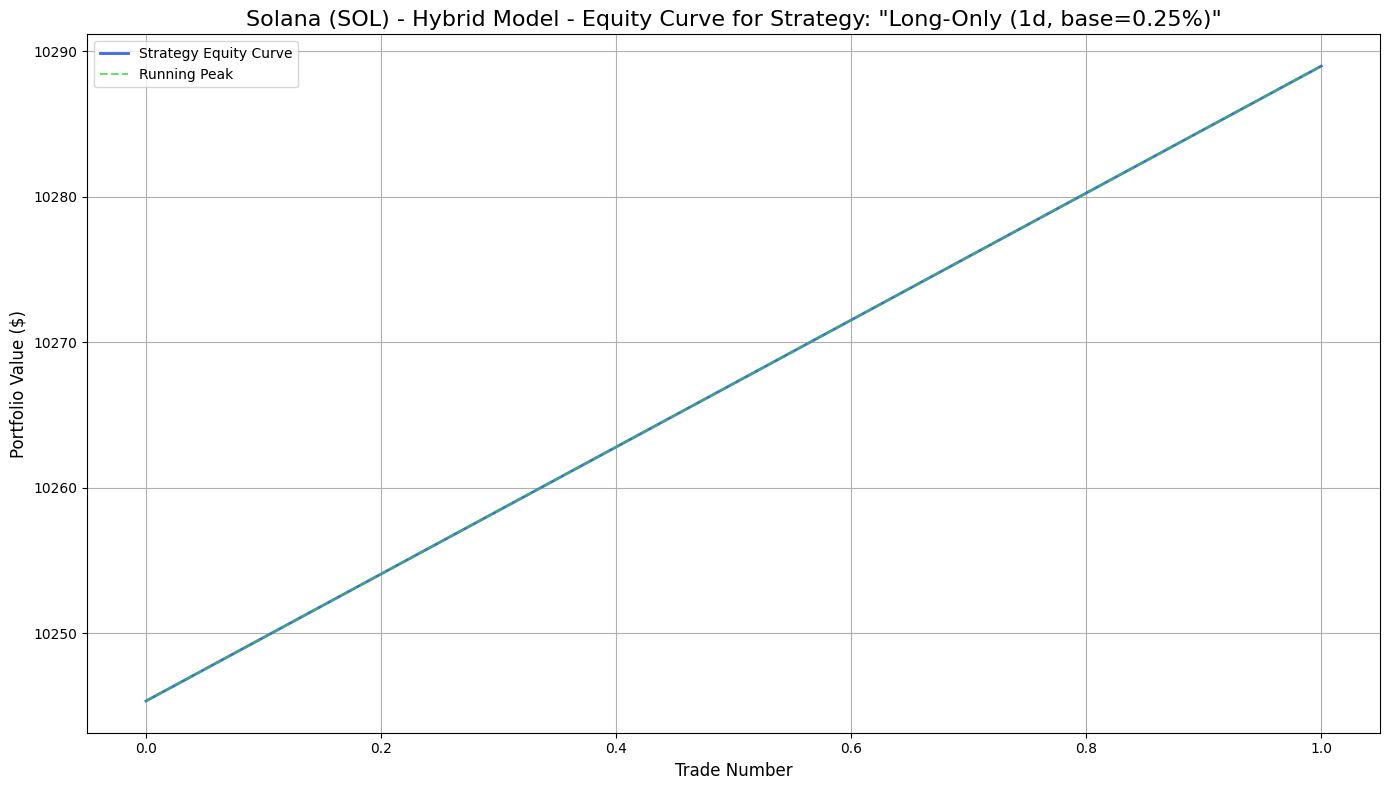


--- Running Backtest for Strategy: Long-Short (1d, base=0.25%) ---
Parameters: {'name': 'Long-Short (1d, base=0.25%)', 'type': 'long_short', 'trade_threshold': 0.008333333333333333, 'holding_period': 1, 'prediction_target': 'Target_1_Day_Pct_Change'}
Simulating trades with fixed holding period...


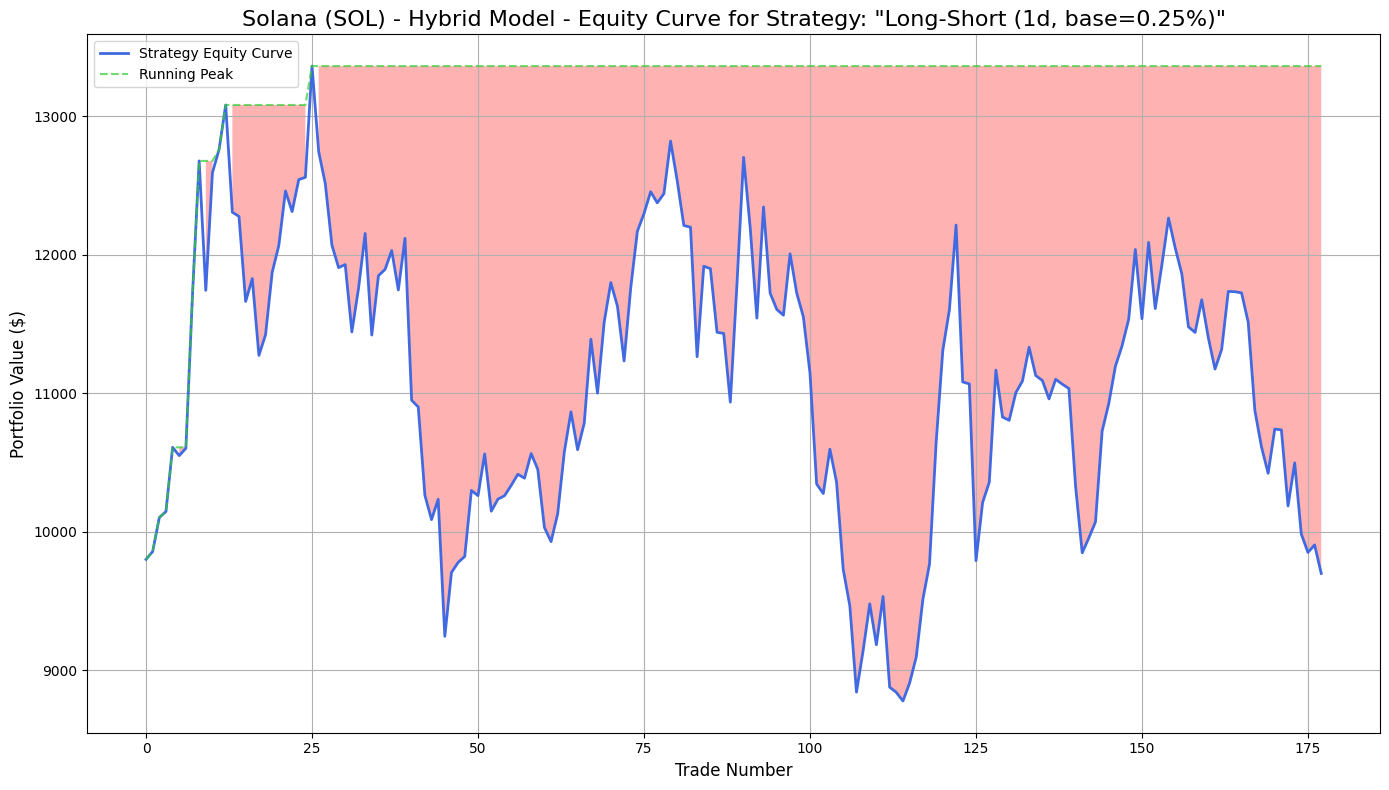


--- Running Backtest for Strategy: Long-Only (1d, base=0.5%) ---
Parameters: {'name': 'Long-Only (1d, base=0.5%)', 'type': 'long_only', 'trade_threshold': 0.016666666666666666, 'holding_period': 1, 'prediction_target': 'Target_1_Day_Pct_Change'}
Simulating trades with fixed holding period...


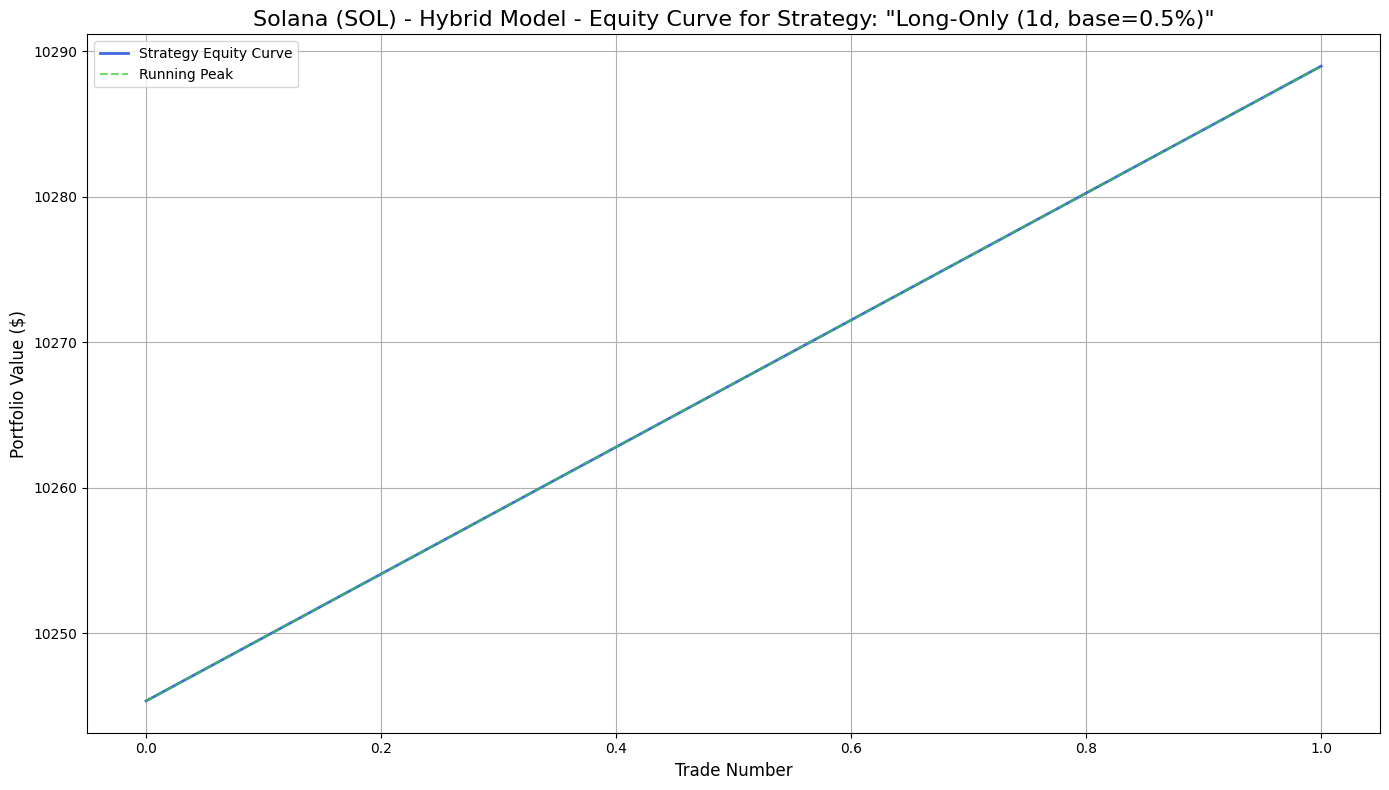


--- Running Backtest for Strategy: Long-Short (1d, base=0.5%) ---
Parameters: {'name': 'Long-Short (1d, base=0.5%)', 'type': 'long_short', 'trade_threshold': 0.016666666666666666, 'holding_period': 1, 'prediction_target': 'Target_1_Day_Pct_Change'}
Simulating trades with fixed holding period...


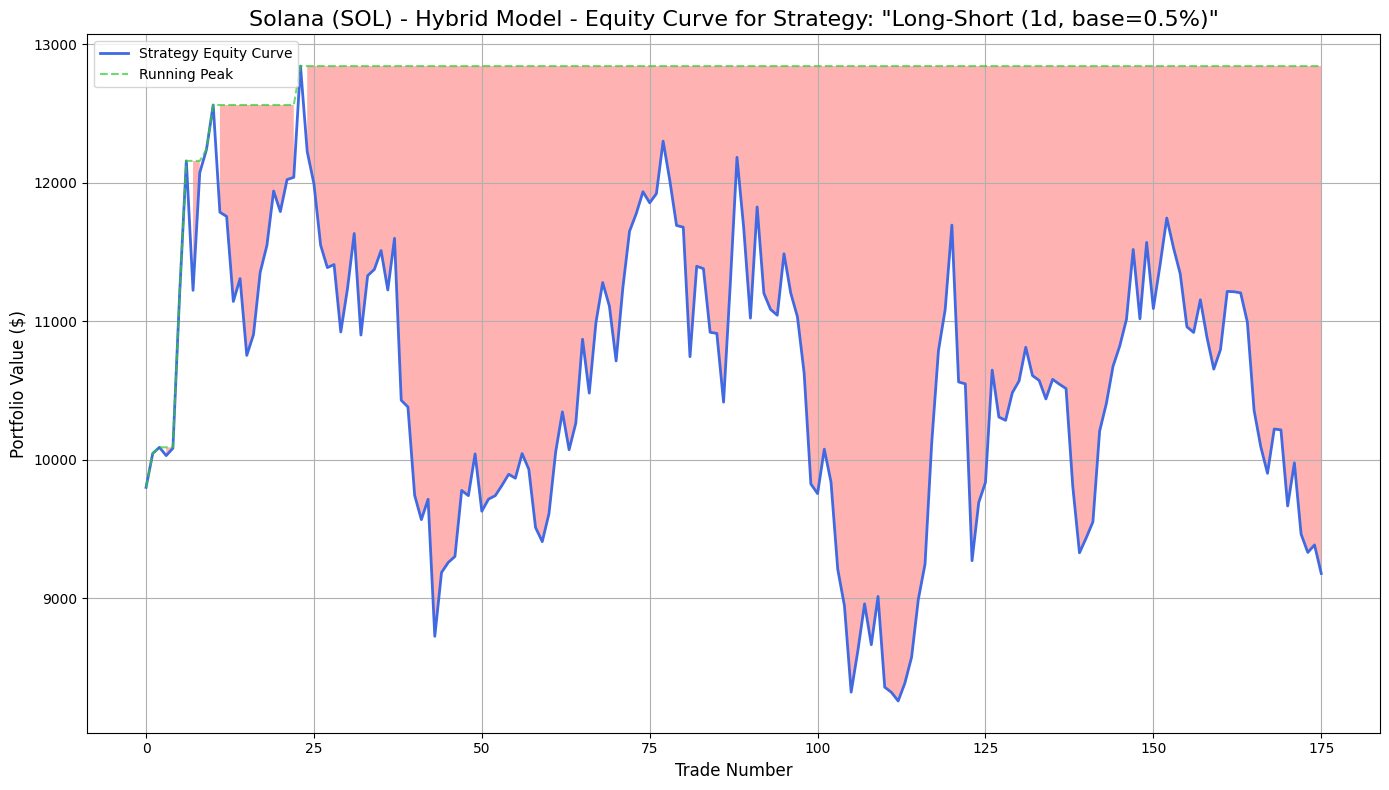


--- Running Backtest for Strategy: Long-Only (1d, base=1.0%) ---
Parameters: {'name': 'Long-Only (1d, base=1.0%)', 'type': 'long_only', 'trade_threshold': 0.03333333333333333, 'holding_period': 1, 'prediction_target': 'Target_1_Day_Pct_Change'}
Simulating trades with fixed holding period...


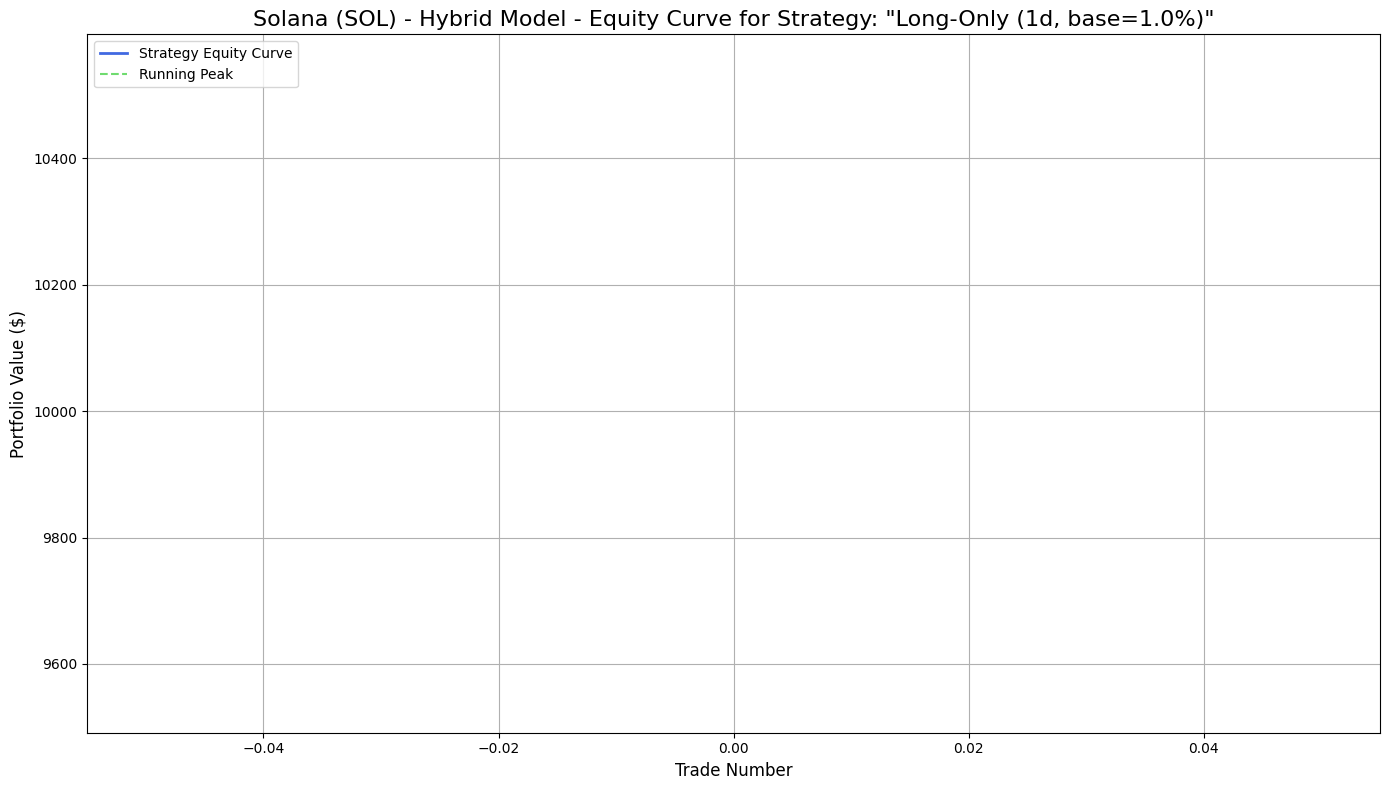


--- Running Backtest for Strategy: Long-Short (1d, base=1.0%) ---
Parameters: {'name': 'Long-Short (1d, base=1.0%)', 'type': 'long_short', 'trade_threshold': 0.03333333333333333, 'holding_period': 1, 'prediction_target': 'Target_1_Day_Pct_Change'}
Simulating trades with fixed holding period...


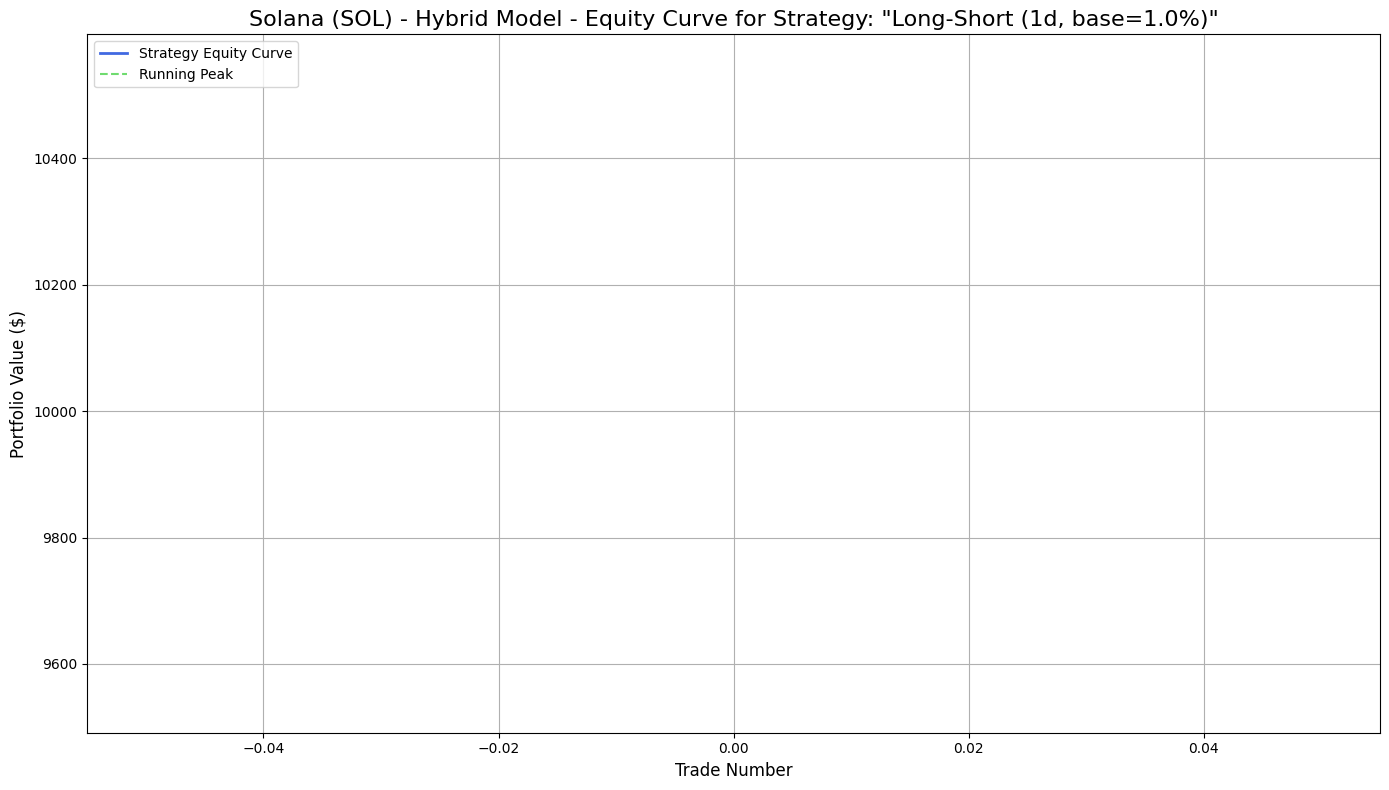


--- Running Backtest for Strategy: Long-Only (7d, base=0.25%) ---
Parameters: {'name': 'Long-Only (7d, base=0.25%)', 'type': 'long_only', 'trade_threshold': 0.058333333333333334, 'holding_period': 7, 'prediction_target': 'Target_7_Day_Pct_Change'}
Simulating trades with fixed holding period...

--- No trades were triggered for this strategy. ---

--- Running Backtest for Strategy: Long-Short (7d, base=0.25%) ---
Parameters: {'name': 'Long-Short (7d, base=0.25%)', 'type': 'long_short', 'trade_threshold': 0.058333333333333334, 'holding_period': 7, 'prediction_target': 'Target_7_Day_Pct_Change'}
Simulating trades with fixed holding period...


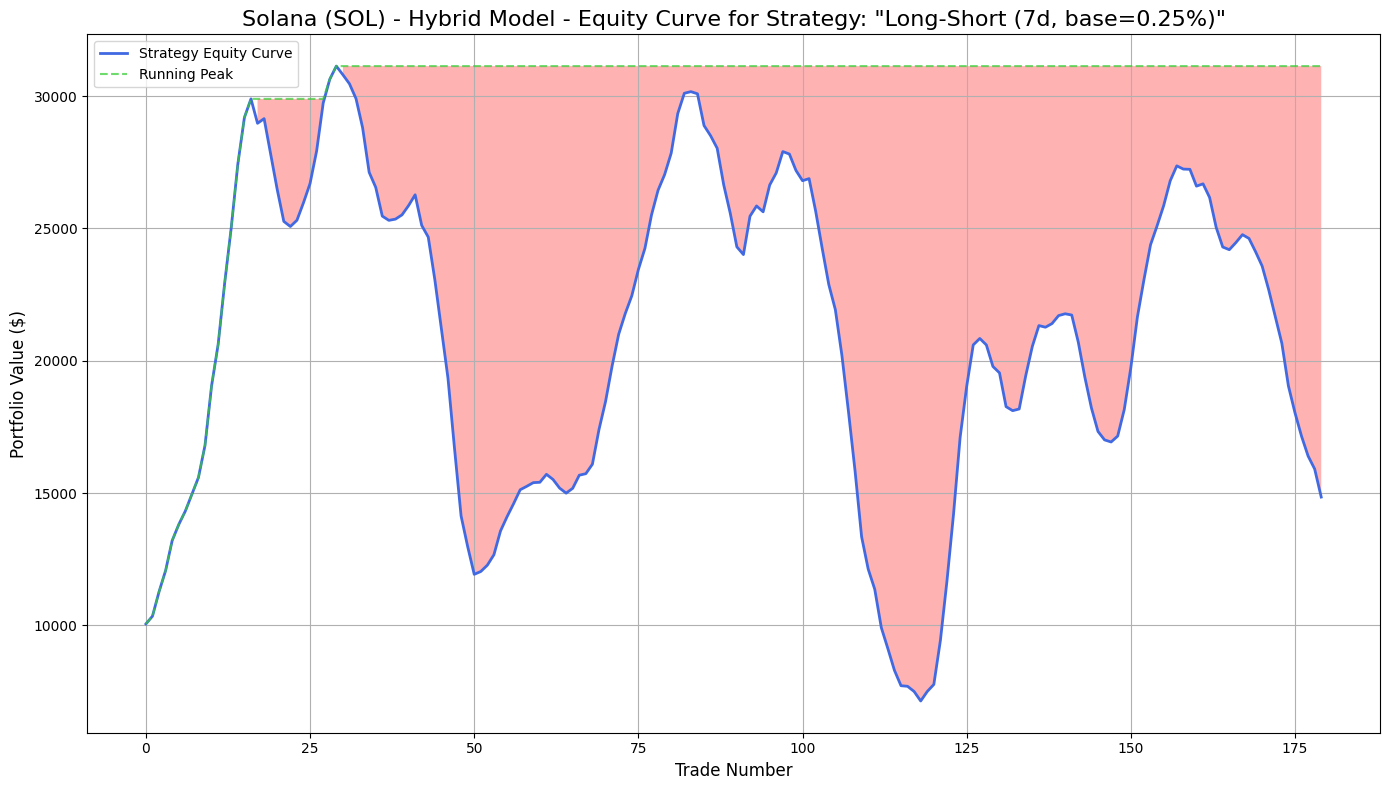


--- Running Backtest for Strategy: Long-Only (7d, base=0.5%) ---
Parameters: {'name': 'Long-Only (7d, base=0.5%)', 'type': 'long_only', 'trade_threshold': 0.11666666666666667, 'holding_period': 7, 'prediction_target': 'Target_7_Day_Pct_Change'}
Simulating trades with fixed holding period...

--- No trades were triggered for this strategy. ---

--- Running Backtest for Strategy: Long-Short (7d, base=0.5%) ---
Parameters: {'name': 'Long-Short (7d, base=0.5%)', 'type': 'long_short', 'trade_threshold': 0.11666666666666667, 'holding_period': 7, 'prediction_target': 'Target_7_Day_Pct_Change'}
Simulating trades with fixed holding period...


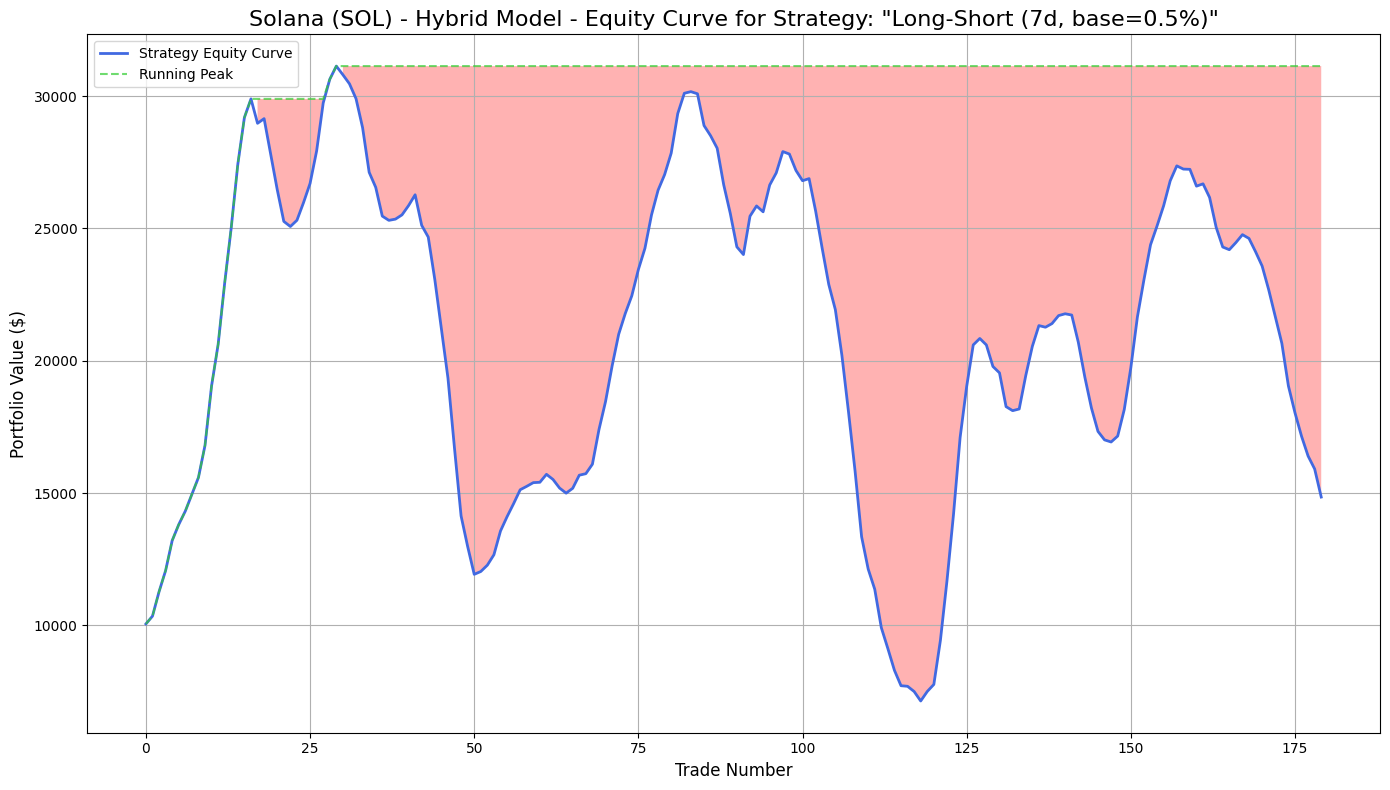


--- Running Backtest for Strategy: Long-Only (7d, base=1.0%) ---
Parameters: {'name': 'Long-Only (7d, base=1.0%)', 'type': 'long_only', 'trade_threshold': 0.23333333333333334, 'holding_period': 7, 'prediction_target': 'Target_7_Day_Pct_Change'}
Simulating trades with fixed holding period...

--- No trades were triggered for this strategy. ---

--- Running Backtest for Strategy: Long-Short (7d, base=1.0%) ---
Parameters: {'name': 'Long-Short (7d, base=1.0%)', 'type': 'long_short', 'trade_threshold': 0.23333333333333334, 'holding_period': 7, 'prediction_target': 'Target_7_Day_Pct_Change'}
Simulating trades with fixed holding period...


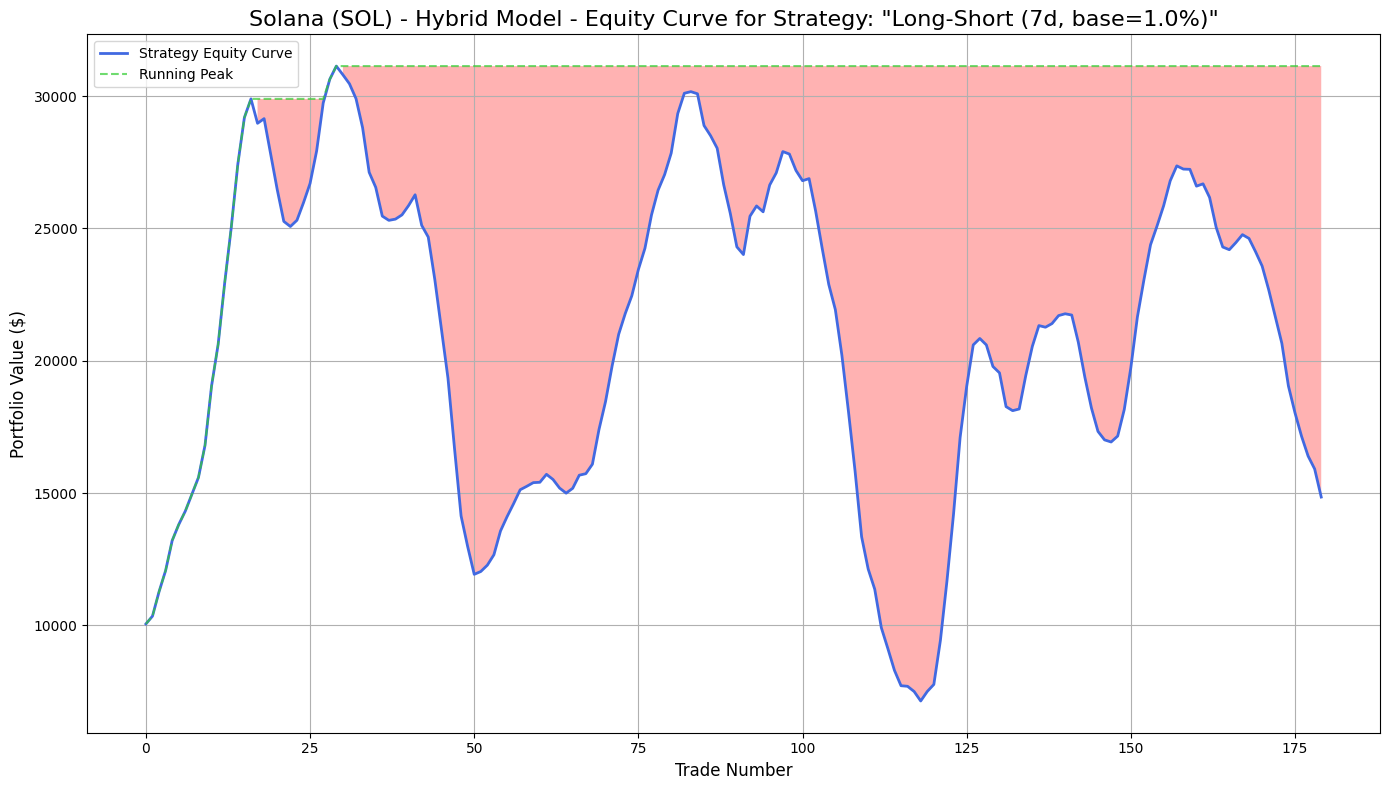


--- Running Backtest for Strategy: Long-Only (30d, base=0.25%) ---
Parameters: {'name': 'Long-Only (30d, base=0.25%)', 'type': 'long_only', 'trade_threshold': 0.25, 'holding_period': 30, 'prediction_target': 'Target_30_Day_Pct_Change'}
Simulating trades with fixed holding period...

--- No trades were triggered for this strategy. ---

--- Running Backtest for Strategy: Long-Short (30d, base=0.25%) ---
Parameters: {'name': 'Long-Short (30d, base=0.25%)', 'type': 'long_short', 'trade_threshold': 0.25, 'holding_period': 30, 'prediction_target': 'Target_30_Day_Pct_Change'}
Simulating trades with fixed holding period...


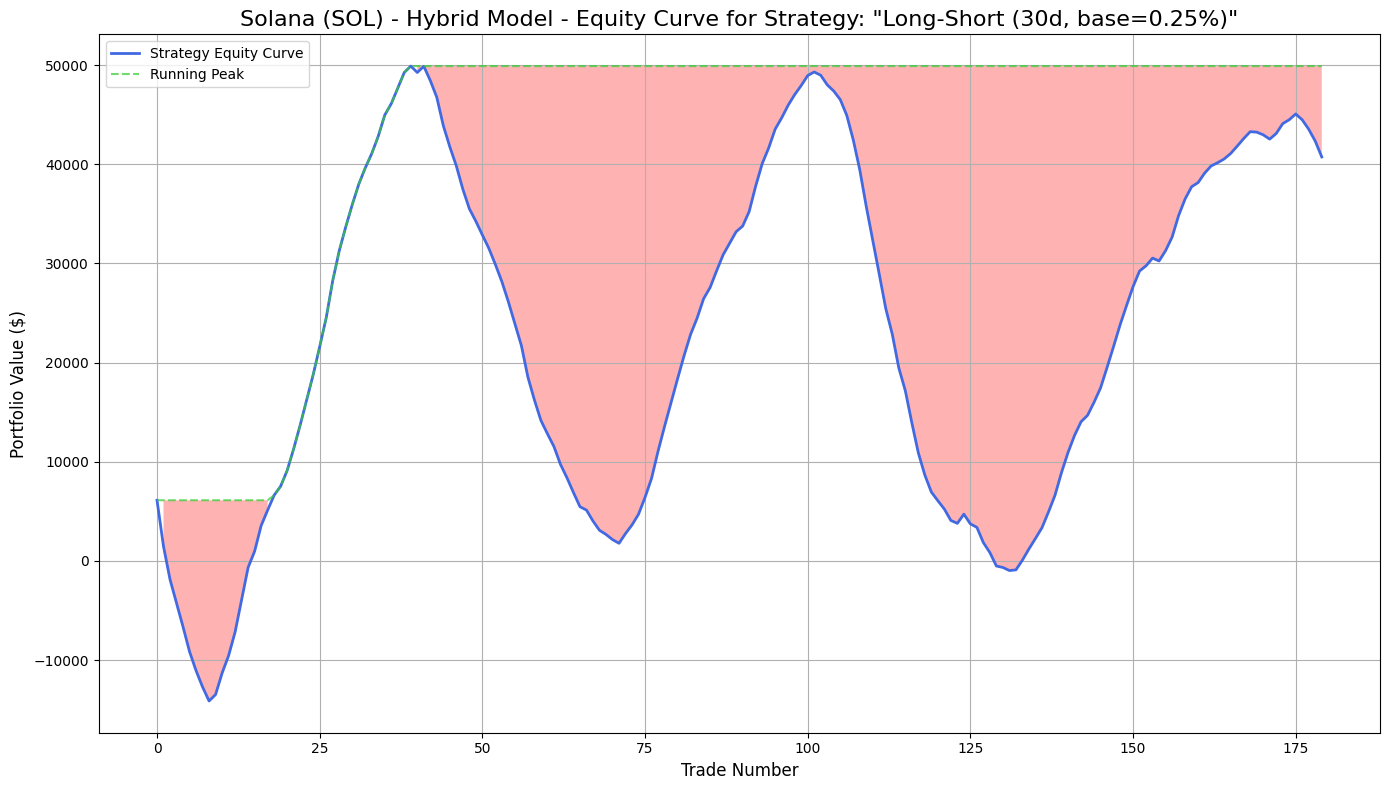


--- Running Backtest for Strategy: Long-Only (30d, base=0.5%) ---
Parameters: {'name': 'Long-Only (30d, base=0.5%)', 'type': 'long_only', 'trade_threshold': 0.5, 'holding_period': 30, 'prediction_target': 'Target_30_Day_Pct_Change'}
Simulating trades with fixed holding period...

--- No trades were triggered for this strategy. ---

--- Running Backtest for Strategy: Long-Short (30d, base=0.5%) ---
Parameters: {'name': 'Long-Short (30d, base=0.5%)', 'type': 'long_short', 'trade_threshold': 0.5, 'holding_period': 30, 'prediction_target': 'Target_30_Day_Pct_Change'}
Simulating trades with fixed holding period...


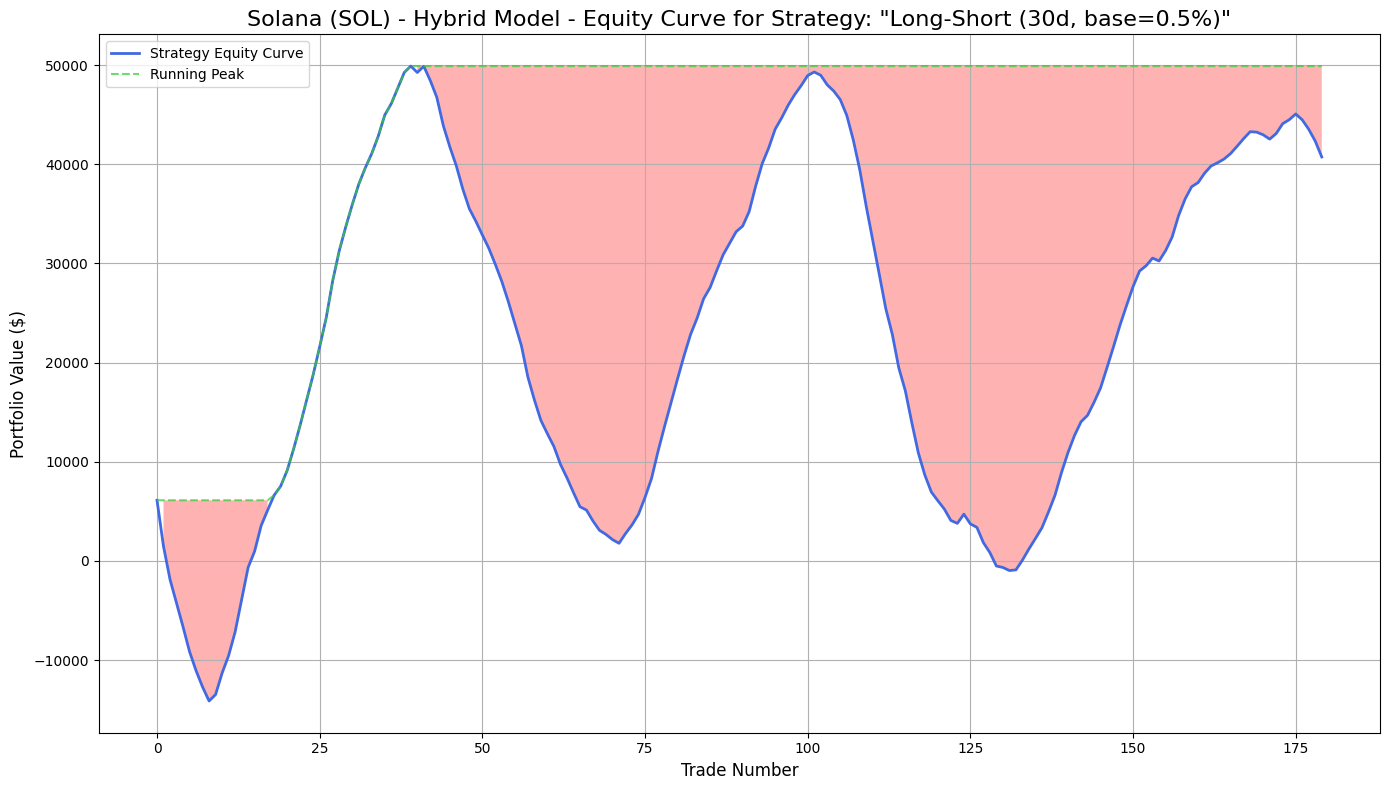


--- Running Backtest for Strategy: Long-Only (30d, base=1.0%) ---
Parameters: {'name': 'Long-Only (30d, base=1.0%)', 'type': 'long_only', 'trade_threshold': 1.0, 'holding_period': 30, 'prediction_target': 'Target_30_Day_Pct_Change'}
Simulating trades with fixed holding period...

--- No trades were triggered for this strategy. ---

--- Running Backtest for Strategy: Long-Short (30d, base=1.0%) ---
Parameters: {'name': 'Long-Short (30d, base=1.0%)', 'type': 'long_short', 'trade_threshold': 1.0, 'holding_period': 30, 'prediction_target': 'Target_30_Day_Pct_Change'}
Simulating trades with fixed holding period...


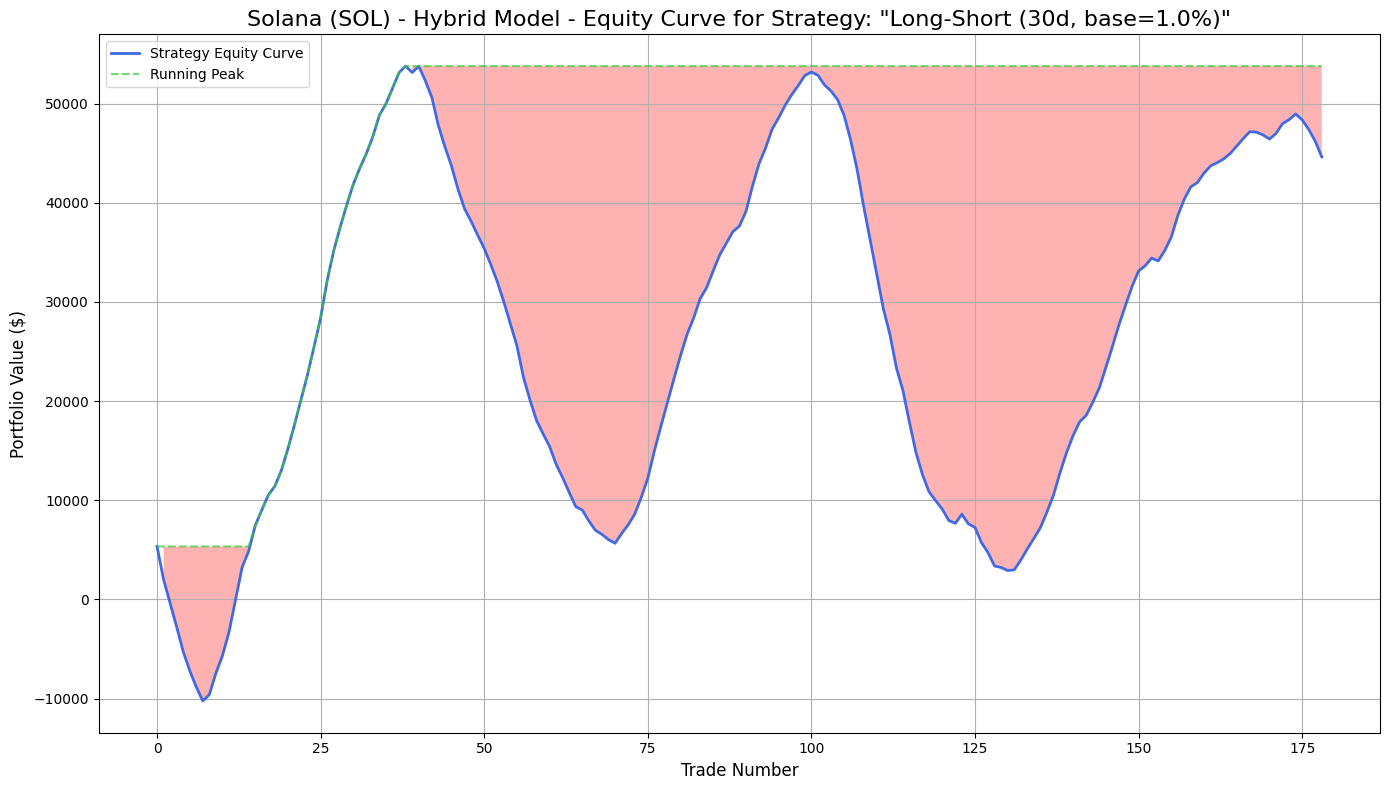


--- Running Backtest for Strategy: Long-Only (90d, base=0.25%) ---
Parameters: {'name': 'Long-Only (90d, base=0.25%)', 'type': 'long_only', 'trade_threshold': 0.75, 'holding_period': 90, 'prediction_target': 'Target_90_Day_Pct_Change'}
Simulating trades with fixed holding period...

--- No trades were triggered for this strategy. ---

--- Running Backtest for Strategy: Long-Short (90d, base=0.25%) ---
Parameters: {'name': 'Long-Short (90d, base=0.25%)', 'type': 'long_short', 'trade_threshold': 0.75, 'holding_period': 90, 'prediction_target': 'Target_90_Day_Pct_Change'}
Simulating trades with fixed holding period...


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_19480\4063108877.py:103: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = ((final_capital / initial_capital) ** (1 / years_in_test) - 1) * 100 if years_in_test > 0 else strategy_total_return


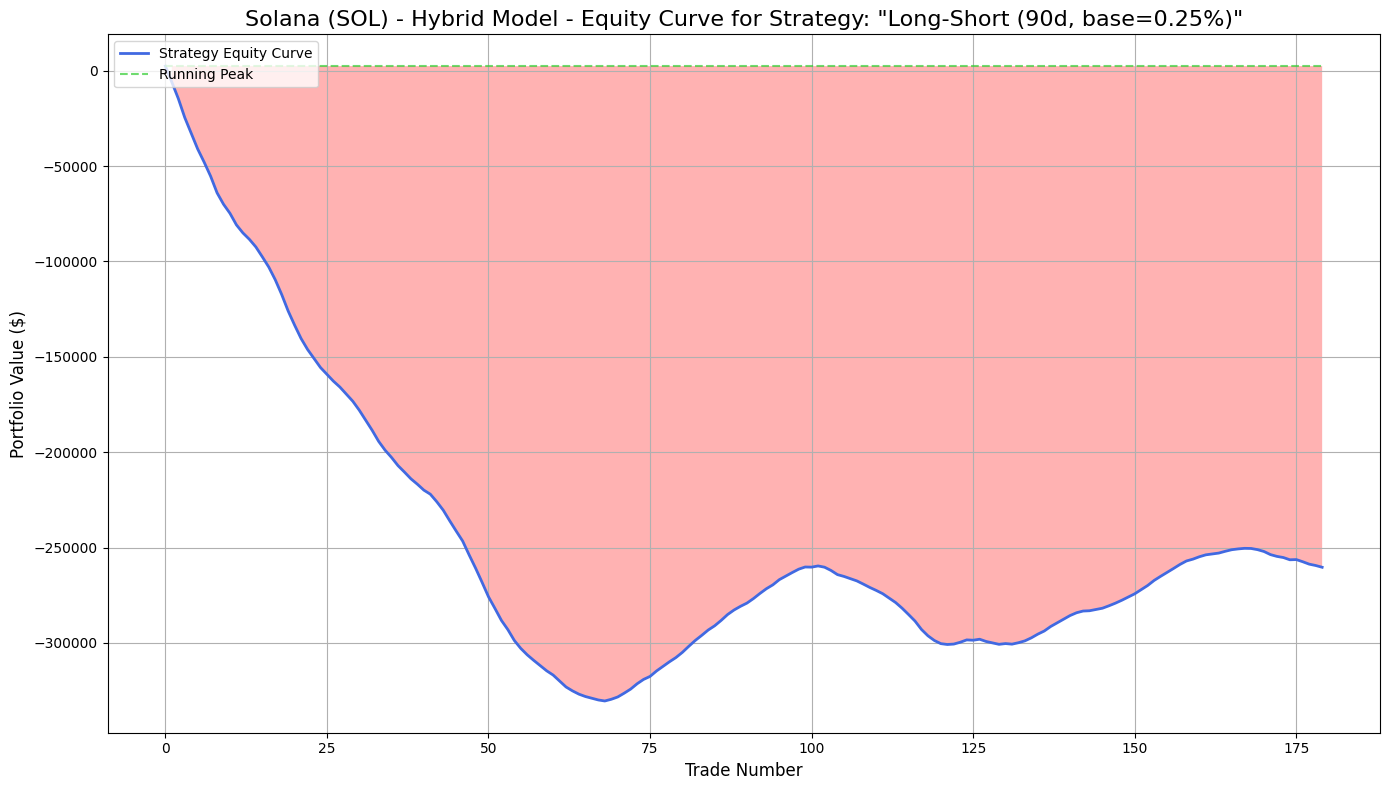


--- Running Backtest for Strategy: Long-Only (90d, base=0.5%) ---
Parameters: {'name': 'Long-Only (90d, base=0.5%)', 'type': 'long_only', 'trade_threshold': 1.5, 'holding_period': 90, 'prediction_target': 'Target_90_Day_Pct_Change'}
Simulating trades with fixed holding period...

--- No trades were triggered for this strategy. ---

--- Running Backtest for Strategy: Long-Short (90d, base=0.5%) ---
Parameters: {'name': 'Long-Short (90d, base=0.5%)', 'type': 'long_short', 'trade_threshold': 1.5, 'holding_period': 90, 'prediction_target': 'Target_90_Day_Pct_Change'}
Simulating trades with fixed holding period...


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_19480\4063108877.py:103: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = ((final_capital / initial_capital) ** (1 / years_in_test) - 1) * 100 if years_in_test > 0 else strategy_total_return


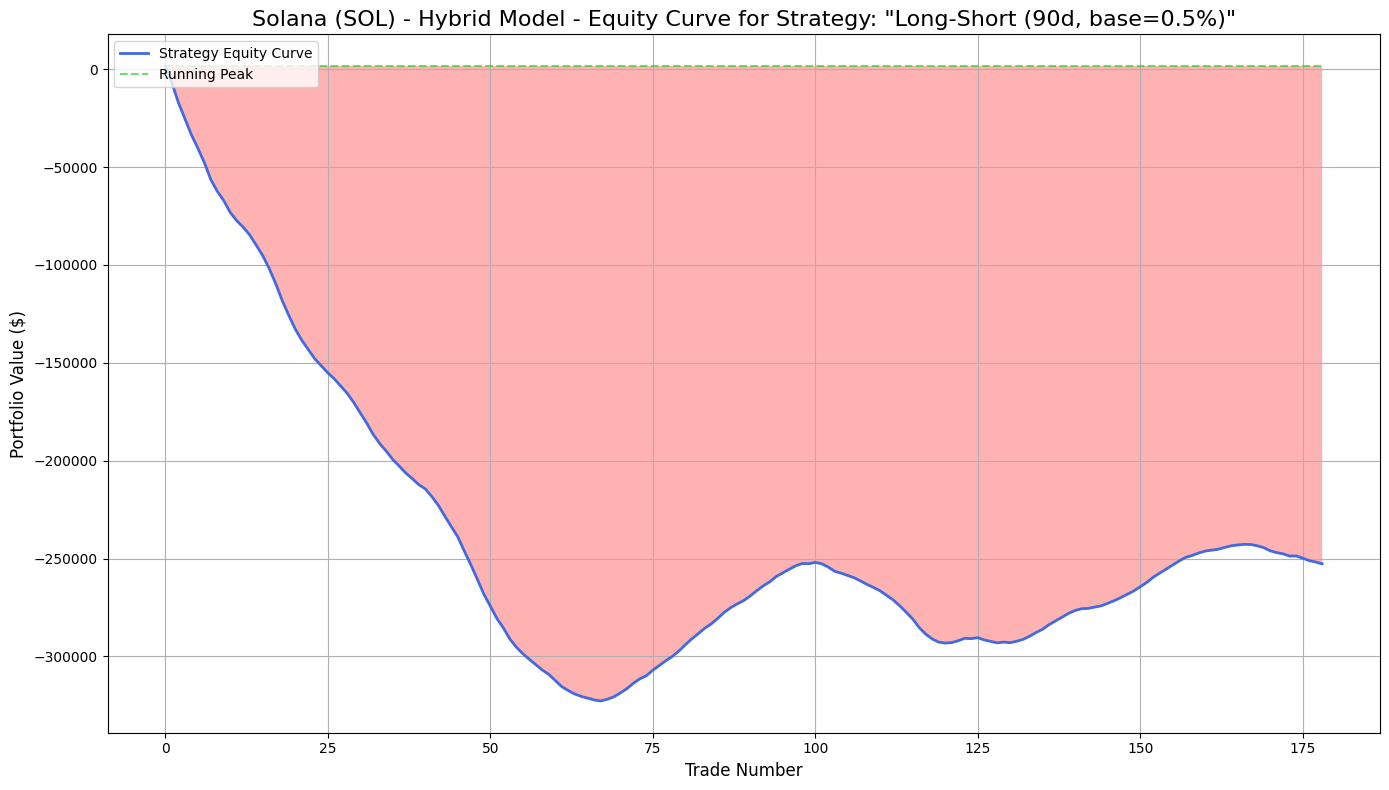


--- Running Backtest for Strategy: Long-Only (90d, base=1.0%) ---
Parameters: {'name': 'Long-Only (90d, base=1.0%)', 'type': 'long_only', 'trade_threshold': 3.0, 'holding_period': 90, 'prediction_target': 'Target_90_Day_Pct_Change'}
Simulating trades with fixed holding period...

--- No trades were triggered for this strategy. ---

--- Running Backtest for Strategy: Long-Short (90d, base=1.0%) ---
Parameters: {'name': 'Long-Short (90d, base=1.0%)', 'type': 'long_short', 'trade_threshold': 3.0, 'holding_period': 90, 'prediction_target': 'Target_90_Day_Pct_Change'}
Simulating trades with fixed holding period...


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_19480\4063108877.py:103: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = ((final_capital / initial_capital) ** (1 / years_in_test) - 1) * 100 if years_in_test > 0 else strategy_total_return


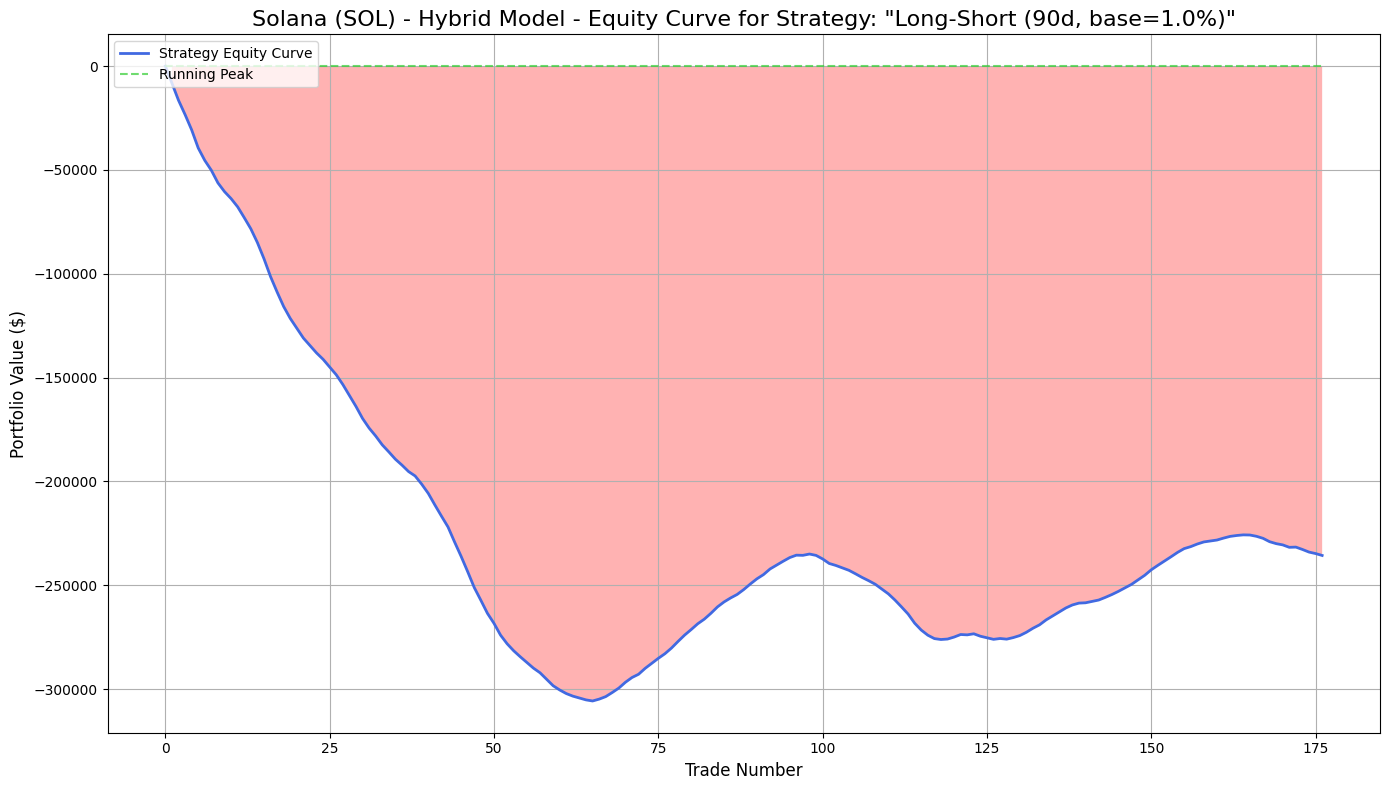



--- MASTER STRATEGY COMPARISON (SOLANA) ---
                              Total Return (%)  Buy & Hold (%)  Sharpe Ratio  \
Strategy                                                                       
Long-Only (1d, base=0.25%)                2.89          -11.85          2.04   
Long-Short (1d, base=0.25%)              -3.01          -11.85         -0.07   
Long-Only (1d, base=0.5%)                 2.89          -11.85          2.04   
Long-Short (1d, base=0.5%)               -8.21          -11.85         -0.20   
Long-Only (1d, base=1.0%)                 0.44          -11.85           NaN   
Long-Short (1d, base=1.0%)                0.44          -11.85           NaN   
Long-Short (7d, base=0.25%)              48.51          -14.08          0.47   
Long-Short (7d, base=0.5%)               48.51          -14.08          0.47   
Long-Short (7d, base=1.0%)               48.51          -14.08          0.47   
Long-Short (30d, base=0.25%)            307.37           19.98          1.

In [17]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# --- 1. Model Definition (Must match the trained model) ---
class HybridLSTM(nn.Module):
    def __init__(self, input_features, hidden_units, num_outputs):
        super(HybridLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_features, hidden_size=hidden_units, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(input_size=hidden_units, hidden_size=hidden_units, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(in_features=hidden_units, out_features=25)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_features=25, out_features=num_outputs)

    def forward(self, x):
        out, _ = self.lstm1(x); out = self.dropout1(out)
        out, _ = self.lstm2(out); out = self.dropout2(out)
        out = out[:, -1, :]; out = self.fc1(out)
        out = self.relu(out); out = self.fc2(out)
        return out

def run_backtest(asset_name, model_path, npz_path, raw_data_path, strategy_config):
    """
    A comprehensive backtesting function that simulates a given strategy and calculates advanced metrics.
    """
    strategy_name = strategy_config['name']
    print(f"\n{'='*30}\n--- Running Backtest for Strategy: {strategy_name} ---\n{'='*30}")
    print(f"Parameters: {strategy_config}")

    try:
        # --- Load Data & Model ---
        with np.load(npz_path, allow_pickle=True) as data:
            X_test, target_cols = data['X_test'], data['target_cols']
            X_test = X_test.astype(np.float32)

        raw_df = pd.read_csv(raw_data_path)
        # Handle Solana's specific format ('time' string)
        raw_df['time'] = pd.to_datetime(raw_df['time'])
        raw_df.sort_values('time', inplace=True)
        raw_df.reset_index(drop=True, inplace=True)
        
        required_len = len(X_test) + strategy_config['holding_period']
        test_prices_df = raw_df.tail(required_len).copy().reset_index(drop=True)
        
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model = HybridLSTM(X_test.shape[2], 40, len(target_cols)).to(device)
        model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
        model.eval()

        # --- Make Predictions ---
        test_loader = DataLoader(TensorDataset(torch.from_numpy(X_test)), batch_size=256)
        all_preds = [];
        with torch.no_grad():
            for batch_X_tuple in test_loader:
                preds = model(batch_X_tuple[0].to(device))
                all_preds.append(preds.cpu().numpy())
        predictions = np.concatenate(all_preds, axis=0)
            
        target_col_index = np.where(target_cols == strategy_config['prediction_target'])[0][0]
        final_predictions = predictions[:, target_col_index]

        # --- Simulate Trades (Unified Logic) ---
        print("Simulating trades with fixed holding period...")
        trades = []
        holding_period = strategy_config['holding_period']
        threshold = strategy_config['trade_threshold']
        
        for i in range(len(final_predictions)):
            if i + holding_period >= len(test_prices_df): break
            prediction = final_predictions[i]
            entry_price = test_prices_df['Close'].iloc[i]
            exit_price = test_prices_df['Close'].iloc[i + holding_period]

            if prediction > threshold:
                trades.append({"return_pct": ((exit_price - entry_price) / entry_price) * 100})
            elif strategy_config['type'] == 'long_short' and prediction < -threshold:
                trades.append({"return_pct": ((entry_price - exit_price) / entry_price) * 100})

        if not trades: print("\n--- No trades were triggered for this strategy. ---"); return None

        # --- Calculate Metrics ---
        trades_df = pd.DataFrame(trades)
        total_trades = len(trades_df); winning_trades_df = trades_df[trades_df['return_pct'] > 0]; win_rate = len(winning_trades_df) / total_trades * 100
        avg_return_per_trade = trades_df['return_pct'].mean(); avg_profit_on_winners = winning_trades_df['return_pct'].mean()
        initial_capital = 10000; returns_series = trades_df['return_pct'] / 100; pnl_series = returns_series * initial_capital
        equity_curve = pnl_series.cumsum() + initial_capital; final_capital = equity_curve.iloc[-1]
        strategy_total_return = (final_capital - initial_capital) / initial_capital * 100
        days_in_test_period = (test_prices_df['time'].iloc[-1] - test_prices_df['time'].iloc[0]).days
        if returns_series.std() != 0 and days_in_test_period > 0 and total_trades > 0:
            sharpe_ratio = returns_series.mean() / returns_series.std()
            # Annualize based on daily data frequency
            annualization_factor = np.sqrt(365 / (days_in_test_period / total_trades))
            annualized_sharpe = sharpe_ratio * annualization_factor
        else: annualized_sharpe = 0
        peak = equity_curve.expanding(min_periods=1).max(); drawdown = (equity_curve - peak) / peak
        max_drawdown_pct = drawdown.min() * -100 if not drawdown.empty else 0
        years_in_test = days_in_test_period / 365.25 if days_in_test_period > 0 else 1
        annualized_return = ((final_capital / initial_capital) ** (1 / years_in_test) - 1) * 100 if years_in_test > 0 else strategy_total_return
        calmar_ratio = annualized_return / max_drawdown_pct if max_drawdown_pct > 0 else 0
        buy_hold_return = (test_prices_df['Close'].iloc[-1] - test_prices_df['Close'].iloc[0]) / test_prices_df['Close'].iloc[0] * 100
        
        # --- Plotting ---
        fig, ax = plt.subplots(figsize=(14, 8)); ax.plot(equity_curve.index, equity_curve, label='Strategy Equity Curve', color='royalblue', linewidth=2)
        ax.plot(peak.index, peak, label='Running Peak', color='limegreen', linestyle='--', alpha=0.7); ax.fill_between(drawdown.index, equity_curve, peak, where=equity_curve < peak, facecolor='red', alpha=0.3)
        ax.set_title(f'{asset_name} - Equity Curve for Strategy: "{strategy_name}"', fontsize=16); ax.set_xlabel('Trade Number', fontsize=12); ax.set_ylabel('Portfolio Value ($)', fontsize=12)
        ax.legend(loc='upper left'); ax.grid(True); plt.tight_layout(); plt.show()
        
        return {"Strategy": strategy_name, "Total Return (%)": strategy_total_return, "Buy & Hold (%)": buy_hold_return, "Sharpe Ratio": annualized_sharpe, "Calmar Ratio": calmar_ratio, "Max Drawdown (%)": max_drawdown_pct, "Win Rate (%)": win_rate, "Total Trades": total_trades}

    except Exception as e:
        print(f"An error occurred during backtest for '{strategy_name}': {e}")
        return None

def main():
    # --- Master Configuration for Solana ---
    master_config = {
        "asset_name": "Solana (SOL) - Hybrid Model",
        "model_path": "solana_hybrid_pytorch_model.pth",
        "npz_path": "solana_hybrid_pytorch_data.npz",
        "raw_data_path": "E:\BAMD\Solana\Solana_daily_data_2018_2024.csv",
    }

    horizons = {
        "1d": {"holding_period": 1, "target_col": "Target_1_Day_Pct_Change"},
        "7d": {"holding_period": 7, "target_col": "Target_7_Day_Pct_Change"},
        "30d": {"holding_period": 30, "target_col": "Target_30_Day_Pct_Change"},
        "90d": {"holding_period": 90, "target_col": "Target_90_Day_Pct_Change"},
    }
    base_thresholds = [0.25, 0.5, 1.0]
    strategy_types = ["long_only", "long_short"]

    all_strategies = []
    # --- Programmatically Generate All 24 Strategies ---
    for horizon_name, horizon_props in horizons.items():
        for base_thresh in base_thresholds:
            # For daily data, the scaling is different. We scale relative to a 30-day period.
            days_in_horizon = horizon_props["holding_period"]
            scaled_threshold = base_thresh * (days_in_horizon / 30.0)

            for strat_type in strategy_types:
                strategy_name_human = f"{strat_type.replace('_','-').title()} ({horizon_name}, base={base_thresh}%)"
                all_strategies.append({
                    "name": strategy_name_human,
                    "type": strat_type,
                    "trade_threshold": scaled_threshold,
                    "holding_period": horizon_props["holding_period"],
                    "prediction_target": horizon_props["target_col"],
                })

    summary_results = []
    for strategy_config in all_strategies:
        result = run_backtest(**master_config, strategy_config=strategy_config)
        if result:
            summary_results.append(result)
    
    if summary_results:
        print("\n\n" + "="*40); print("--- MASTER STRATEGY COMPARISON (SOLANA) ---"); print("="*40)
        summary_df = pd.DataFrame(summary_results).set_index("Strategy")
        pd.options.display.float_format = '{:,.2f}'.format
        print(summary_df)

if __name__ == "__main__":
    main()


--- Running Backtest for Strategy: Long-Only (1d, base=0.25%) ---
Parameters: {'name': 'Long-Only (1d, base=0.25%)', 'type': 'long_only', 'trade_threshold': 0.25, 'holding_period': 1, 'prediction_target': 'Target_1_Day_Pct_Change'}

--- No trades were triggered. ---

--- Running Backtest for Strategy: Long-Short (1d, base=0.25%) ---
Parameters: {'name': 'Long-Short (1d, base=0.25%)', 'type': 'long_short', 'trade_threshold': 0.25, 'holding_period': 1, 'prediction_target': 'Target_1_Day_Pct_Change'}

--- No trades were triggered. ---

--- Running Backtest for Strategy: Long-Only (1d, base=0.5%) ---
Parameters: {'name': 'Long-Only (1d, base=0.5%)', 'type': 'long_only', 'trade_threshold': 0.5, 'holding_period': 1, 'prediction_target': 'Target_1_Day_Pct_Change'}

--- No trades were triggered. ---

--- Running Backtest for Strategy: Long-Short (1d, base=0.5%) ---
Parameters: {'name': 'Long-Short (1d, base=0.5%)', 'type': 'long_short', 'trade_threshold': 0.5, 'holding_period': 1, 'prediction

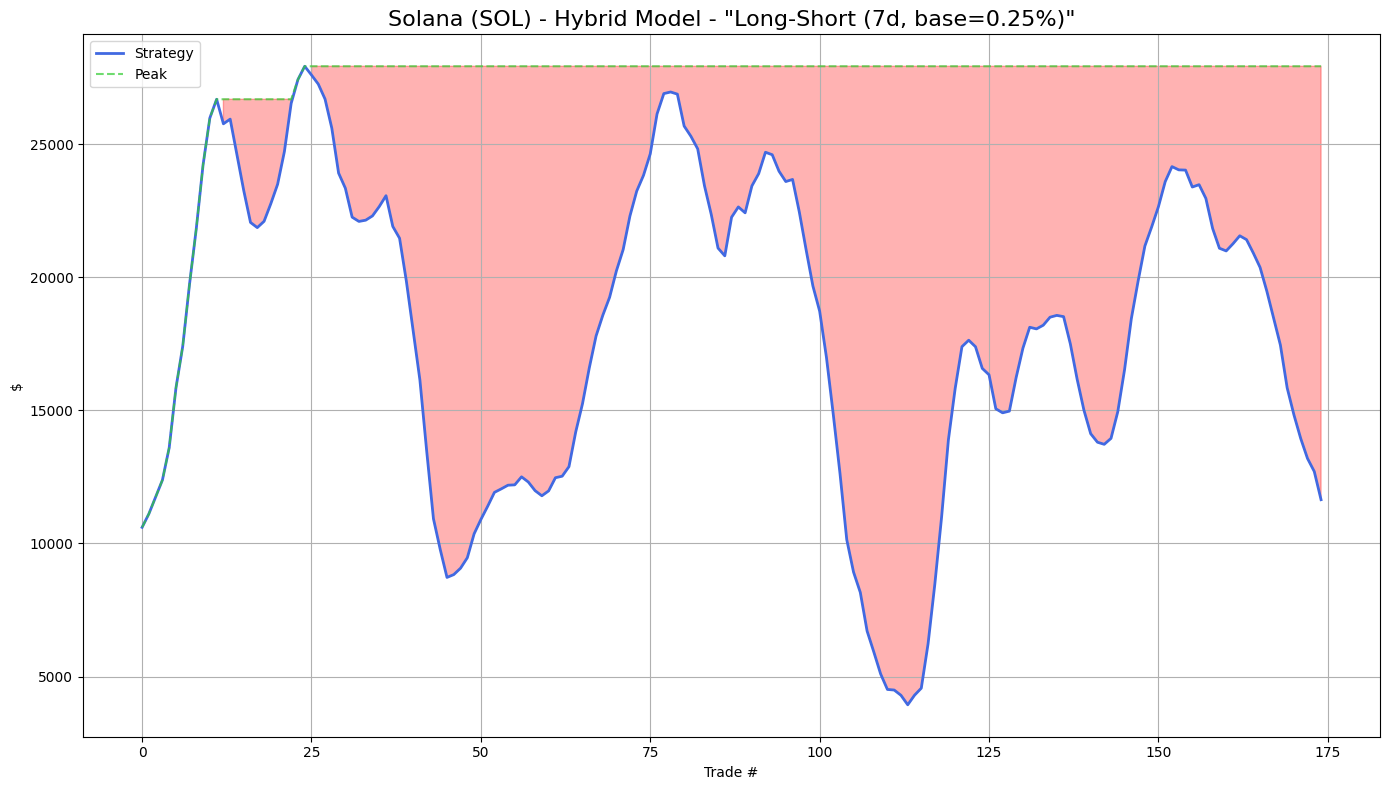


--- Running Backtest for Strategy: Long-Only (7d, base=0.5%) ---
Parameters: {'name': 'Long-Only (7d, base=0.5%)', 'type': 'long_only', 'trade_threshold': 3.5, 'holding_period': 7, 'prediction_target': 'Target_7_Day_Pct_Change'}

--- No trades were triggered. ---

--- Running Backtest for Strategy: Long-Short (7d, base=0.5%) ---
Parameters: {'name': 'Long-Short (7d, base=0.5%)', 'type': 'long_short', 'trade_threshold': 3.5, 'holding_period': 7, 'prediction_target': 'Target_7_Day_Pct_Change'}

--- No trades were triggered. ---

--- Running Backtest for Strategy: Long-Only (7d, base=1.0%) ---
Parameters: {'name': 'Long-Only (7d, base=1.0%)', 'type': 'long_only', 'trade_threshold': 7.0, 'holding_period': 7, 'prediction_target': 'Target_7_Day_Pct_Change'}

--- No trades were triggered. ---

--- Running Backtest for Strategy: Long-Short (7d, base=1.0%) ---
Parameters: {'name': 'Long-Short (7d, base=1.0%)', 'type': 'long_short', 'trade_threshold': 7.0, 'holding_period': 7, 'prediction_targe

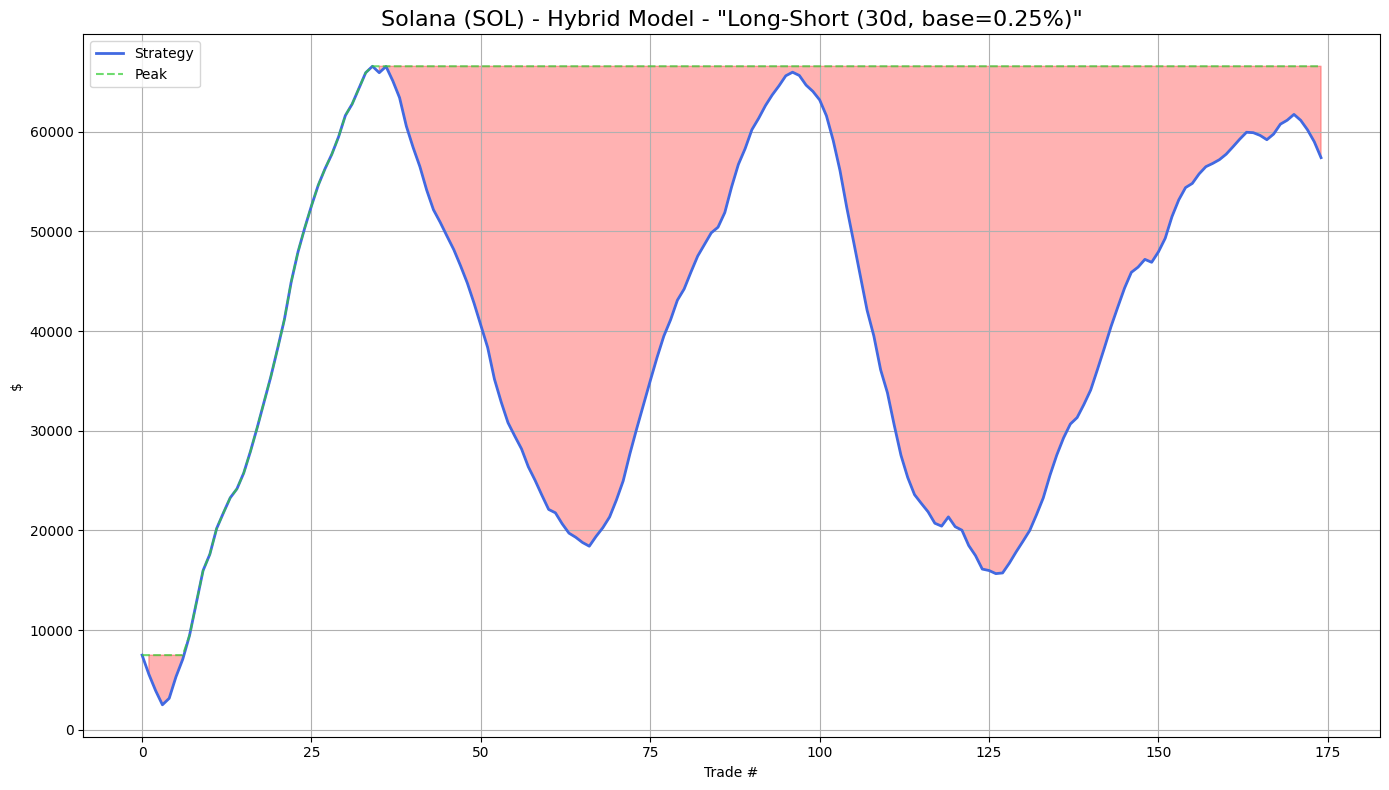


--- Running Backtest for Strategy: Long-Only (30d, base=0.5%) ---
Parameters: {'name': 'Long-Only (30d, base=0.5%)', 'type': 'long_only', 'trade_threshold': 15.0, 'holding_period': 30, 'prediction_target': 'Target_30_Day_Pct_Change'}

--- No trades were triggered. ---

--- Running Backtest for Strategy: Long-Short (30d, base=0.5%) ---
Parameters: {'name': 'Long-Short (30d, base=0.5%)', 'type': 'long_short', 'trade_threshold': 15.0, 'holding_period': 30, 'prediction_target': 'Target_30_Day_Pct_Change'}

--- No trades were triggered. ---

--- Running Backtest for Strategy: Long-Only (30d, base=1.0%) ---
Parameters: {'name': 'Long-Only (30d, base=1.0%)', 'type': 'long_only', 'trade_threshold': 30.0, 'holding_period': 30, 'prediction_target': 'Target_30_Day_Pct_Change'}

--- No trades were triggered. ---

--- Running Backtest for Strategy: Long-Short (30d, base=1.0%) ---
Parameters: {'name': 'Long-Short (30d, base=1.0%)', 'type': 'long_short', 'trade_threshold': 30.0, 'holding_period': 30

In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# --- 1. Model Definition (Must match the trained model) ---
class HybridLSTM(nn.Module):
    def __init__(self, input_features, hidden_units, num_outputs):
        super(HybridLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_features, hidden_size=hidden_units, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(input_size=hidden_units, hidden_size=hidden_units, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(in_features=hidden_units, out_features=25)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_features=25, out_features=num_outputs)

    def forward(self, x):
        out, _ = self.lstm1(x); out = self.dropout1(out)
        out, _ = self.lstm2(out); out = self.dropout2(out)
        out = out[:, -1, :]; out = self.fc1(out)
        out = self.relu(out); out = self.fc2(out)
        return out

def run_backtest(asset_name, model_path, npz_path, raw_data_path, strategy_config):
    strategy_name = strategy_config['name']
    print(f"\n{'='*30}\n--- Running Backtest for Strategy: {strategy_name} ---\n{'='*30}")
    print(f"Parameters: {strategy_config}")

    try:
        with np.load(npz_path, allow_pickle=True) as data: X_test, target_cols = data['X_test'], data['target_cols']
        raw_df = pd.read_csv(raw_data_path); raw_df['time']=pd.to_datetime(raw_df['time']); raw_df.sort_values('time',inplace=True); raw_df.reset_index(drop=True,inplace=True)
        required_len=len(X_test)+strategy_config['holding_period']; test_prices_df=raw_df.tail(required_len).copy().reset_index(drop=True)
        device="cuda" if torch.cuda.is_available() else "cpu"; model=HybridLSTM(X_test.shape[2],40,len(target_cols)).to(device); model.load_state_dict(torch.load(model_path,map_location=torch.device(device))); model.eval()
        test_loader=DataLoader(TensorDataset(torch.from_numpy(X_test.astype(np.float32))),batch_size=256); all_preds=[]
        with torch.no_grad():
            for b in test_loader: p=model(b[0].to(device)); all_preds.append(p.cpu().numpy())
        predictions=np.concatenate(all_preds,axis=0); target_col_index=np.where(target_cols==strategy_config['prediction_target'])[0][0]; final_predictions=predictions[:,target_col_index]
        trades=[]
        if strategy_config['type']=='long_only':
            for i in range(len(final_predictions)):
                if i+strategy_config['holding_period']>=len(test_prices_df): break
                if final_predictions[i]>strategy_config['trade_threshold']: entry=test_prices_df['Close'].iloc[i]; exit_price=test_prices_df['Close'].iloc[i+strategy_config['holding_period']]; trades.append({"return_pct":((exit_price-entry)/entry)*100})
        elif strategy_config['type']=='long_short':
            for i in range(len(final_predictions)):
                if i+strategy_config['holding_period']>=len(test_prices_df): break
                prediction=final_predictions[i]; entry_price=test_prices_df['Close'].iloc[i]; exit_price=test_prices_df['Close'].iloc[i+strategy_config['holding_period']]
                if prediction>strategy_config['trade_threshold']: trades.append({"return_pct":((exit_price-entry_price)/entry_price)*100})
                elif prediction<-strategy_config['trade_threshold']: trades.append({"return_pct":((entry_price-exit_price)/entry_price)*100})
        if not trades: print("\n--- No trades were triggered. ---"); return None
        trades_df=pd.DataFrame(trades); total_trades=len(trades_df); win_df=trades_df[trades_df['return_pct']>0]; win_rate=len(win_df)/total_trades*100
        initial_capital=10000; returns_series=trades_df['return_pct']/100; pnl_series=returns_series*initial_capital; equity_curve=pnl_series.cumsum()+initial_capital
        final_capital=equity_curve.iloc[-1]; strategy_total_return=(final_capital-initial_capital)/initial_capital*100; days_in_test=(test_prices_df['time'].iloc[-1]-test_prices_df['time'].iloc[0]).days
        if returns_series.std()!=0 and days_in_test>0 and total_trades>0: sharp=returns_series.mean()/returns_series.std(); ann_factor=np.sqrt(365/(days_in_test/total_trades)); ann_sharp=sharp*ann_factor
        else: ann_sharp=0
        peak=equity_curve.expanding(min_periods=1).max(); drawdown=(equity_curve-peak)/peak; max_dd=drawdown.min()*-100 if not drawdown.empty else 0
        years_in_test=days_in_test/365.25 if days_in_test>0 else 1; ann_return=((final_capital/initial_capital)**(1/years_in_test)-1)*100 if years_in_test>0 else strategy_total_return
        calmar=ann_return/max_dd if max_dd>0 else 0; buy_hold=(test_prices_df['Close'].iloc[-1]-test_prices_df['Close'].iloc[0])/test_prices_df['Close'].iloc[0]*100
        fig,ax=plt.subplots(figsize=(14,8)); ax.plot(equity_curve.index,equity_curve,label='Strategy',color='royalblue',lw=2); ax.plot(peak.index,peak,label='Peak',color='limegreen',ls='--',alpha=0.7); ax.fill_between(drawdown.index,equity_curve,peak,where=equity_curve<peak,color='red',alpha=0.3)
        ax.set_title(f'{asset_name} - "{strategy_name}"',fontsize=16); ax.set_xlabel('Trade #'); ax.set_ylabel('$'); ax.legend(loc='upper left'); ax.grid(True); plt.tight_layout(); plt.show()
        return {"Strategy":strategy_name, "Total Return (%)":strategy_total_return, "Buy & Hold (%)":buy_hold, "Sharpe Ratio":ann_sharp, "Calmar Ratio":calmar, "Max Drawdown (%)":max_dd, "Win Rate (%)":win_rate, "Total Trades":total_trades}
    except Exception as e: print(f"Error for '{strategy_name}': {e}"); return None

def main():
    master_config = {"asset_name": "Solana (SOL) - Hybrid Model", "model_path": "solana_hybrid_pytorch_model.pth", "npz_path": "solana_hybrid_pytorch_data.npz", "raw_data_path": "E:\\BAMD\\Solana\\Solana_daily_data_2018_2024.csv"}
    horizons = {"1d": {"holding_period": 1, "target_col": "Target_1_Day_Pct_Change"}, "7d": {"holding_period": 7, "target_col": "Target_7_Day_Pct_Change"}, "30d": {"holding_period": 30, "target_col": "Target_30_Day_Pct_Change"}, "90d": {"holding_period": 90, "target_col": "Target_90_Day_Pct_Change"}}
    base_thresholds = [0.25, 0.5, 1.0]; strategy_types = ["long_only", "long_short"]
    all_strategies = []
    for h_name, h_props in horizons.items():
        for b_thresh in base_thresholds:
            days_in_horizon = h_props["holding_period"]
            scaled_threshold = b_thresh * days_in_horizon
            for s_type in strategy_types:
                name = f"{s_type.replace('_','-').title()} ({h_name}, base={b_thresh}%)"
                all_strategies.append({
                    "name": name,
                    "type": s_type,
                    # --- THIS IS THE CORRECTED LINE ---
                    "trade_threshold": scaled_threshold, 
                    # --- END OF CORRECTION ---
                    "holding_period": h_props["holding_period"],
                    "prediction_target": h_props["target_col"]
                })
    summary_results = [r for s_config in all_strategies if (r := run_backtest(**master_config, strategy_config=s_config)) is not None]
    if summary_results:
        print("\n\n" + "="*40); print("--- MASTER STRATEGY COMPARISON (SOLANA) ---"); print("="*40)
        summary_df = pd.DataFrame(summary_results).set_index("Strategy"); pd.options.display.float_format = '{:,.2f}'.format; print(summary_df)
        output_csv_filename = "solana_backtest_summary.csv"; summary_df.to_csv(output_csv_filename, float_format='%.2f'); print(f"\nSummary also saved to: {output_csv_filename}")
if __name__ == "__main__": main()


--- Running Backtest for Strategy: Long-Only (1d, base=0.25%) ---
Parameters: {'name': 'Long-Only (1d, base=0.25%)', 'type': 'long_only', 'trade_threshold': 0.25, 'holding_period': 1, 'prediction_target': 'Target_1_Day_Pct_Change'}

--- No trades were triggered. ---

--- Running Backtest for Strategy: Long-Short (1d, base=0.25%) ---
Parameters: {'name': 'Long-Short (1d, base=0.25%)', 'type': 'long_short', 'trade_threshold': 0.25, 'holding_period': 1, 'prediction_target': 'Target_1_Day_Pct_Change'}

--- No trades were triggered. ---

--- Running Backtest for Strategy: Long-Only (1d, base=0.5%) ---
Parameters: {'name': 'Long-Only (1d, base=0.5%)', 'type': 'long_only', 'trade_threshold': 0.5, 'holding_period': 1, 'prediction_target': 'Target_1_Day_Pct_Change'}

--- No trades were triggered. ---

--- Running Backtest for Strategy: Long-Short (1d, base=0.5%) ---
Parameters: {'name': 'Long-Short (1d, base=0.5%)', 'type': 'long_short', 'trade_threshold': 0.5, 'holding_period': 1, 'prediction

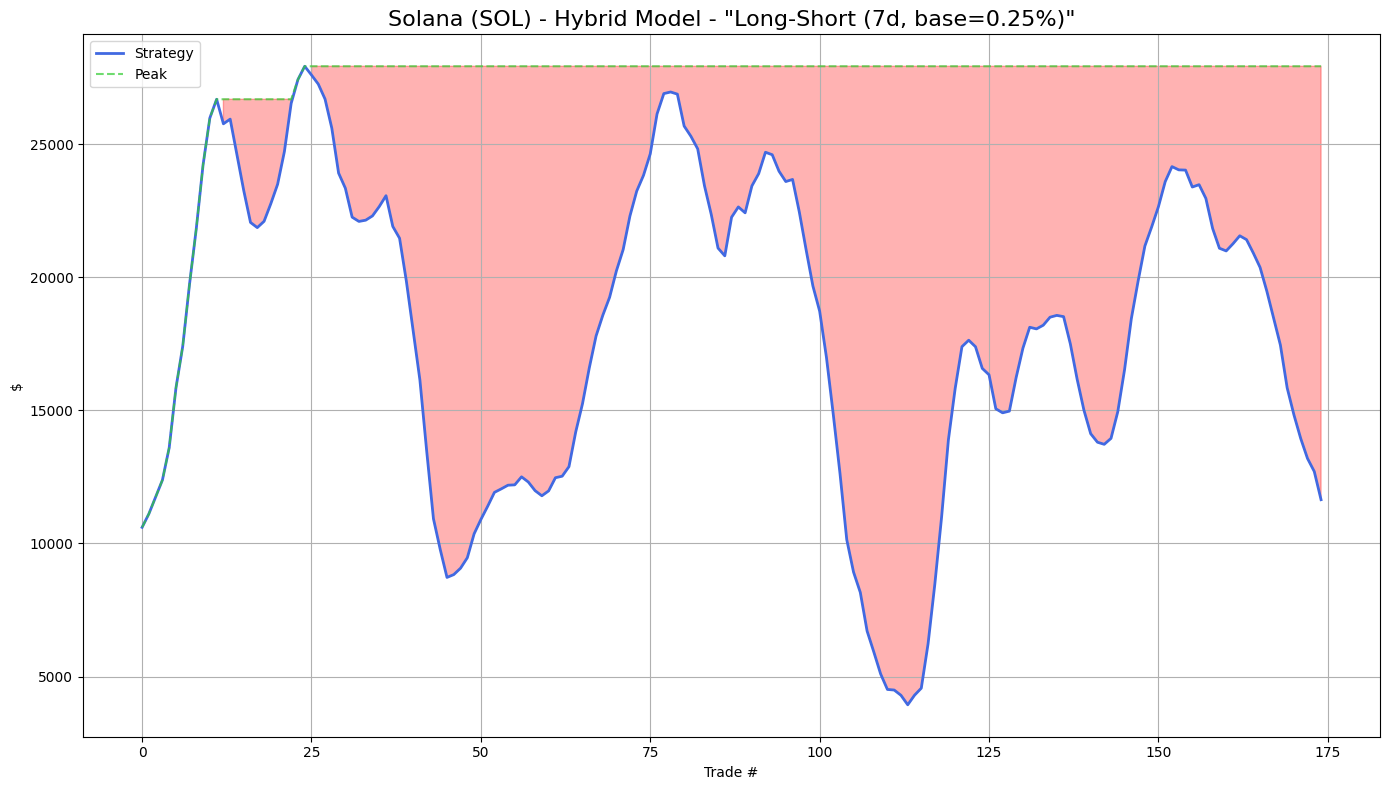


--- Running Backtest for Strategy: Long-Only (7d, base=0.5%) ---
Parameters: {'name': 'Long-Only (7d, base=0.5%)', 'type': 'long_only', 'trade_threshold': 3.5, 'holding_period': 7, 'prediction_target': 'Target_7_Day_Pct_Change'}

--- No trades were triggered. ---

--- Running Backtest for Strategy: Long-Short (7d, base=0.5%) ---
Parameters: {'name': 'Long-Short (7d, base=0.5%)', 'type': 'long_short', 'trade_threshold': 3.5, 'holding_period': 7, 'prediction_target': 'Target_7_Day_Pct_Change'}

--- No trades were triggered. ---

--- Running Backtest for Strategy: Long-Only (7d, base=1.0%) ---
Parameters: {'name': 'Long-Only (7d, base=1.0%)', 'type': 'long_only', 'trade_threshold': 7.0, 'holding_period': 7, 'prediction_target': 'Target_7_Day_Pct_Change'}

--- No trades were triggered. ---

--- Running Backtest for Strategy: Long-Short (7d, base=1.0%) ---
Parameters: {'name': 'Long-Short (7d, base=1.0%)', 'type': 'long_short', 'trade_threshold': 7.0, 'holding_period': 7, 'prediction_targe

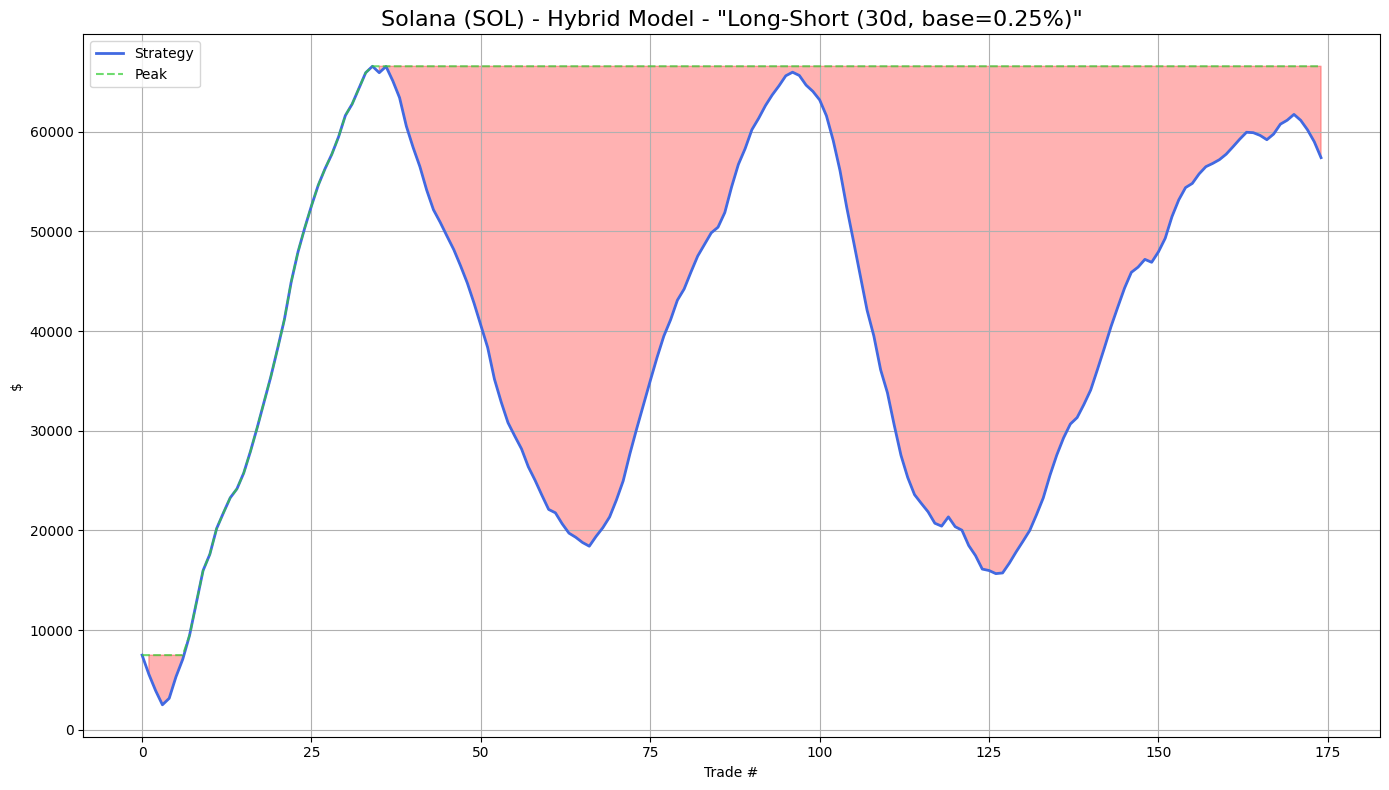


--- Running Backtest for Strategy: Long-Only (30d, base=0.5%) ---
Parameters: {'name': 'Long-Only (30d, base=0.5%)', 'type': 'long_only', 'trade_threshold': 15.0, 'holding_period': 30, 'prediction_target': 'Target_30_Day_Pct_Change'}

--- No trades were triggered. ---

--- Running Backtest for Strategy: Long-Short (30d, base=0.5%) ---
Parameters: {'name': 'Long-Short (30d, base=0.5%)', 'type': 'long_short', 'trade_threshold': 15.0, 'holding_period': 30, 'prediction_target': 'Target_30_Day_Pct_Change'}

--- No trades were triggered. ---

--- Running Backtest for Strategy: Long-Only (30d, base=1.0%) ---
Parameters: {'name': 'Long-Only (30d, base=1.0%)', 'type': 'long_only', 'trade_threshold': 30.0, 'holding_period': 30, 'prediction_target': 'Target_30_Day_Pct_Change'}

--- No trades were triggered. ---

--- Running Backtest for Strategy: Long-Short (30d, base=1.0%) ---
Parameters: {'name': 'Long-Short (30d, base=1.0%)', 'type': 'long_short', 'trade_threshold': 30.0, 'holding_period': 30

In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# --- 1. Model Definition (Must match the trained model) ---
class HybridLSTM(nn.Module):
    def __init__(self, input_features, hidden_units, num_outputs):
        super(HybridLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_features, hidden_size=hidden_units, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(input_size=hidden_units, hidden_size=hidden_units, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(in_features=hidden_units, out_features=25)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_features=25, out_features=num_outputs)

    def forward(self, x):
        out, _ = self.lstm1(x); out = self.dropout1(out)
        out, _ = self.lstm2(out); out = self.dropout2(out)
        out = out[:, -1, :]; out = self.fc1(out)
        out = self.relu(out); out = self.fc2(out)
        return out

def run_backtest(asset_name, model_path, npz_path, raw_data_path, strategy_config):
    strategy_name = strategy_config['name']
    print(f"\n{'='*30}\n--- Running Backtest for Strategy: {strategy_name} ---\n{'='*30}")
    print(f"Parameters: {strategy_config}")

    try:
        with np.load(npz_path, allow_pickle=True) as data: X_test, target_cols = data['X_test'], data['target_cols']
        raw_df = pd.read_csv(raw_data_path); raw_df['time']=pd.to_datetime(raw_df['time']); raw_df.sort_values('time',inplace=True); raw_df.reset_index(drop=True,inplace=True)
        required_len=len(X_test)+strategy_config['holding_period']; test_prices_df=raw_df.tail(required_len).copy().reset_index(drop=True)
        device="cuda" if torch.cuda.is_available() else "cpu"; model=HybridLSTM(X_test.shape[2],40,len(target_cols)).to(device); model.load_state_dict(torch.load(model_path,map_location=torch.device(device))); model.eval()
        test_loader=DataLoader(TensorDataset(torch.from_numpy(X_test.astype(np.float32))),batch_size=256); all_preds=[]
        with torch.no_grad():
            for b in test_loader: p=model(b[0].to(device)); all_preds.append(p.cpu().numpy())
        predictions=np.concatenate(all_preds,axis=0); target_col_index=np.where(target_cols==strategy_config['prediction_target'])[0][0]; final_predictions=predictions[:,target_col_index]
        trades=[]
        if strategy_config['type']=='long_only':
            for i in range(len(final_predictions)):
                if i+strategy_config['holding_period']>=len(test_prices_df): break
                if final_predictions[i]>strategy_config['trade_threshold']: entry=test_prices_df['Close'].iloc[i]; exit_price=test_prices_df['Close'].iloc[i+strategy_config['holding_period']]; trades.append({"return_pct":((exit_price-entry)/entry)*100})
        elif strategy_config['type']=='long_short':
            for i in range(len(final_predictions)):
                if i+strategy_config['holding_period']>=len(test_prices_df): break
                prediction=final_predictions[i]; entry_price=test_prices_df['Close'].iloc[i]; exit_price=test_prices_df['Close'].iloc[i+strategy_config['holding_period']]
                if prediction>strategy_config['trade_threshold']: trades.append({"return_pct":((exit_price-entry_price)/entry_price)*100})
                elif prediction<-strategy_config['trade_threshold']: trades.append({"return_pct":((entry_price-exit_price)/entry_price)*100})
        if not trades: print("\n--- No trades were triggered. ---"); return None
        trades_df=pd.DataFrame(trades); total_trades=len(trades_df); win_df=trades_df[trades_df['return_pct']>0]; win_rate=len(win_df)/total_trades*100
        initial_capital=10000; returns_series=trades_df['return_pct']/100; pnl_series=returns_series*initial_capital; equity_curve=pnl_series.cumsum()+initial_capital
        final_capital=equity_curve.iloc[-1]; strategy_total_return=(final_capital-initial_capital)/initial_capital*100; days_in_test=(test_prices_df['time'].iloc[-1]-test_prices_df['time'].iloc[0]).days
        if returns_series.std()!=0 and days_in_test>0 and total_trades>0: sharp=returns_series.mean()/returns_series.std(); ann_factor=np.sqrt(365/(days_in_test/total_trades)); ann_sharp=sharp*ann_factor
        else: ann_sharp=0
        peak=equity_curve.expanding(min_periods=1).max(); drawdown=(equity_curve-peak)/peak; max_dd=drawdown.min()*-100 if not drawdown.empty else 0
        years_in_test=days_in_test/365.25 if days_in_test>0 else 1; ann_return=((final_capital/initial_capital)**(1/years_in_test)-1)*100 if years_in_test>0 else strategy_total_return
        calmar=ann_return/max_dd if max_dd>0 else 0; buy_hold=(test_prices_df['Close'].iloc[-1]-test_prices_df['Close'].iloc[0])/test_prices_df['Close'].iloc[0]*100
        fig,ax=plt.subplots(figsize=(14,8)); ax.plot(equity_curve.index,equity_curve,label='Strategy',color='royalblue',lw=2); ax.plot(peak.index,peak,label='Peak',color='limegreen',ls='--',alpha=0.7); ax.fill_between(drawdown.index,equity_curve,peak,where=equity_curve<peak,color='red',alpha=0.3)
        ax.set_title(f'{asset_name} - "{strategy_name}"',fontsize=16); ax.set_xlabel('Trade #'); ax.set_ylabel('$'); ax.legend(loc='upper left'); ax.grid(True); plt.tight_layout(); plt.show()
        return {"Strategy":strategy_name, "Total Return (%)":strategy_total_return, "Buy & Hold (%)":buy_hold, "Sharpe Ratio":ann_sharp, "Calmar Ratio":calmar, "Max Drawdown (%)":max_dd, "Win Rate (%)":win_rate, "Total Trades":total_trades}
    except Exception as e: print(f"Error for '{strategy_name}': {e}"); return None

def main():
    master_config = {"asset_name": "Solana (SOL) - Hybrid Model", "model_path": "solana_hybrid_pytorch_model.pth", "npz_path": "solana_hybrid_pytorch_data.npz", "raw_data_path": "E:\\BAMD\\Solana\\Solana_daily_data_2018_2024.csv"}
    horizons = {"1d": {"holding_period": 1, "target_col": "Target_1_Day_Pct_Change"}, "7d": {"holding_period": 7, "target_col": "Target_7_Day_Pct_Change"}, "30d": {"holding_period": 30, "target_col": "Target_30_Day_Pct_Change"}, "90d": {"holding_period": 90, "target_col": "Target_90_Day_Pct_Change"}}
    base_thresholds = [0.25, 0.5, 1.0]; strategy_types = ["long_only", "long_short"]
    all_strategies = []
    for h_name, h_props in horizons.items():
        for b_thresh in base_thresholds:
            days_in_horizon = h_props["holding_period"]
            scaled_threshold = b_thresh * days_in_horizon
            for s_type in strategy_types:
                name = f"{s_type.replace('_','-').title()} ({h_name}, base={b_thresh}%)"
                all_strategies.append({
                    "name": name,
                    "type": s_type,
                    # --- THIS IS THE CORRECTED LINE ---
                    "trade_threshold": scaled_threshold, 
                    # --- END OF CORRECTION ---
                    "holding_period": h_props["holding_period"],
                    "prediction_target": h_props["target_col"]
                })
    summary_results = [r for s_config in all_strategies if (r := run_backtest(**master_config, strategy_config=s_config)) is not None]
    if summary_results:
        print("\n\n" + "="*40); print("--- MASTER STRATEGY COMPARISON (SOLANA) ---"); print("="*40)
        summary_df = pd.DataFrame(summary_results).set_index("Strategy"); pd.options.display.float_format = '{:,.2f}'.format; print(summary_df)
        output_csv_filename = "solana_backtest_summary.csv"; summary_df.to_csv(output_csv_filename, float_format='%.2f'); print(f"\nSummary also saved to: {output_csv_filename}")
if __name__ == "__main__": main()

In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# --- 1. Define the PyTorch Model Architecture ---
# This class must be an exact match to the one used for training
# in order to load the saved weights correctly.
class HybridLSTM(nn.Module):
    def __init__(self, input_features, hidden_units, num_outputs):
        super(HybridLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_features, hidden_size=hidden_units, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(input_size=hidden_units, hidden_size=hidden_units, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(in_features=hidden_units, out_features=25)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_features=25, out_features=num_outputs)

    def forward(self, x):
        out, _ = self.lstm1(x); out = self.dropout1(out)
        out, _ = self.lstm2(out); out = self.dropout2(out)
        out = out[:, -1, :]; out = self.fc1(out)
        out = self.relu(out); out = self.fc2(out)
        return out

def export_predictions_for_solana_hybrid():
    """
    Loads a pre-trained PyTorch Hybrid LSTM model for Solana and its test data,
    aligns it with raw price data, generates predictions, and exports a
    comprehensive CSV file for analysis.
    """
    # --- Parameters ---
    asset_name = "Solana (SOL) - Hybrid Model"
    model_path = "solana_hybrid_pytorch_model.pth"
    npz_path = "solana_hybrid_pytorch_data.npz"
    # Using the exact raw file path you provided
    raw_data_path = "E:\\BAMD\\Solana\\Solana_daily_data_2018_2024.csv"
    output_csv_path = "solana_hybrid_predictions_with_context.csv"

    print(f"--- Exporting Predictions for: {asset_name} ---")

    # 1. Load the Pre-Processed Test Data
    print(f"Loading test data from '{npz_path}'...")
    try:
        with np.load(npz_path, allow_pickle=True) as data:
            X_test, y_test = data['X_test'], data['y_test']
            target_cols = data['target_cols']
    except FileNotFoundError:
        print(f"ERROR: Input data file '{npz_path}' not found. Please ensure it exists.")
        return

    # 2. Load and Clean Raw Data to Align Dates and Prices
    print(f"Loading and cleaning raw data from '{raw_data_path}' for alignment...")
    try:
        raw_df = pd.read_csv(raw_data_path)
        raw_df['time'] = pd.to_datetime(raw_df['time'])
        raw_df.sort_values('time', inplace=True)
        raw_df.reset_index(drop=True, inplace=True)
        
        # We must perform the *exact same* cleaning steps as the preparation script
        # to ensure the row counts match perfectly.
        raw_df['SMA_50'] = raw_df['Close'].rolling(window=50).mean()
        raw_df['temp_target'] = raw_df['Open'].shift(-90) # Longest horizon
        raw_df.replace([np.inf, -np.inf], np.nan, inplace=True)
        raw_df.dropna(inplace=True)
        raw_df.reset_index(drop=True, inplace=True)
        
        # The test set corresponds to the tail end of this cleaned dataframe
        aligned_context_df = raw_df.tail(len(X_test)).copy()
        aligned_context_df = aligned_context_df[['time', 'Close']].reset_index(drop=True)

    except FileNotFoundError:
        print(f"ERROR: Raw data file not found at '{raw_data_path}'.")
        return
    except Exception as e:
        print(f"An error occurred while processing the raw data file: {e}")
        return

    # 3. Load the Pre-Trained PyTorch Model
    print(f"Loading pre-trained PyTorch model from '{model_path}'...")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    try:
        input_features, num_outputs = X_test.shape[2], y_test.shape[1]
        model = HybridLSTM(input_features, hidden_units=40, num_outputs=num_outputs).to(device)
        model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
        model.eval()
    except Exception as e:
        print(f"ERROR: Could not load the model file. Error: {e}")
        return

    # 4. Generate Predictions on the Test Set (in batches)
    print("Generating predictions on the test set...")
    test_loader = DataLoader(TensorDataset(torch.from_numpy(X_test).float()), batch_size=256)
    all_preds = []
    with torch.no_grad():
        for batch_X_tuple in test_loader:
            preds = model(batch_X_tuple[0].to(device))
            all_preds.append(preds.cpu().numpy())
    predictions = np.concatenate(all_preds, axis=0)

    # 5. Create and Export the Final DataFrame
    print(f"Assembling and exporting the final table to '{output_csv_path}'...")
    
    pred_col_names = [f"Pred_{name.replace('Target_', '')}" for name in target_cols]
    
    actuals_df = pd.DataFrame(y_test, columns=target_cols)
    predictions_df = pd.DataFrame(predictions, columns=pred_col_names)
    
    # Combine the context (Date, Price) with the actuals and predictions
    final_df = pd.concat([aligned_context_df, actuals_df, predictions_df], axis=1)
    
    final_df.to_csv(output_csv_path, index=False, float_format='%.6f')
    
    print("\n--- Success! ---")
    print(f"Predictions exported. You can now analyze the file: '{output_csv_path}'")
    print("\nPreview of the first 5 rows:")
    print(final_df.head().to_string())

if __name__ == "__main__":
    export_predictions_for_solana_hybrid()

--- Exporting Predictions for: Solana (SOL) - Hybrid Model ---
Loading test data from 'solana_hybrid_pytorch_data.npz'...
Loading and cleaning raw data from 'E:\BAMD\Solana\Solana_daily_data_2018_2024.csv' for alignment...
Loading pre-trained PyTorch model from 'solana_hybrid_pytorch_model.pth'...
Generating predictions on the test set...
Assembling and exporting the final table to 'solana_hybrid_predictions_with_context.csv'...

--- Success! ---
Predictions exported. You can now analyze the file: 'solana_hybrid_predictions_with_context.csv'

Preview of the first 5 rows:
        time  Close  Target_1_Day_Pct_Change  Target_7_Day_Pct_Change  Target_30_Day_Pct_Change  Target_90_Day_Pct_Change  Pred_1_Day_Pct_Change  Pred_7_Day_Pct_Change  Pred_30_Day_Pct_Change  Pred_90_Day_Pct_Change
0 2024-01-04 105.02                     0.00                    -2.87                     -4.29                     72.84                  -0.02                  -0.25                   -0.90               